In [9]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

# import importlib
# import utils
# importlib.reload(utils)

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [10]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp
import cv2
import scipy
from tqdm import tqdm

import skimage.io as io
import os

In [11]:
import pickle

In [12]:
import sys

In [13]:
sys.path.append('/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/')

In [14]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py'>

# Read in data and trace particle positions

In [16]:
# read the image stack
foldername='/Volumes/maxone/20231012/new/new/0p5low_alg_12p5mM_3500ul_100um_20231013_121507_AM/'
imgname='0p5low_alg_12p5mM_3500ul_100um_20231013_121403_AM_20231013_121507_AM'
img_tif = io.imread(foldername+imgname+'.tif')

In [17]:
framerate=5647

In [18]:
scale_px=74/100 #px/um

In [19]:
ref=img_tif[0]

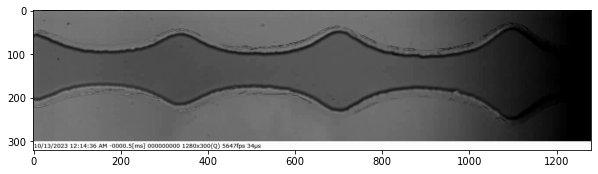

In [20]:
plt.imshow(ref)

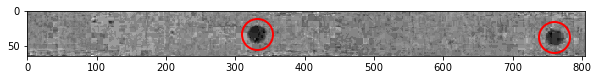

<AxesSubplot:>

In [21]:
crop_ys=104
crop_ye=169

crop_xs=115
crop_xe=920

frame=563
size=31
target=img_tif[frame,crop_ys:crop_ye,crop_xs:crop_xe]-ref[crop_ys:crop_ye,crop_xs:crop_xe]+100
f_locate = tp.locate(target, size, minmass=1500, invert=True)
tp.annotate(f_locate, target, plot_style={'markersize': size})

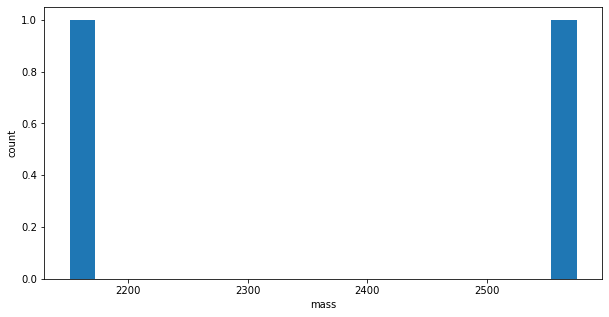

In [22]:
fig, ax = plt.subplots()
ax.hist(f_locate['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

In [23]:
start_frame=0
end_frame=7000


In [24]:
img_tif.shape

(7000, 320, 1280)

In [14]:
with tp.PandasHDFStore(imgname+'.h5') as s:
    tp.batch(img_tif[start_frame:end_frame,crop_ys:crop_ye,crop_xs:crop_xe]-ref[crop_ys:crop_ye,crop_xs:crop_xe]+100,size, minmass=1500, invert=True, processes=1,output=s)

Frame 6999: 0 features


In [15]:
with tp.PandasHDFStore(imgname+'.h5') as s:
    # As before, we require a minimum "life" of 5 frames and a memory of 3 frames
    for linked in tp.link_df_iter(s, 100, memory=0,link_strategy='hybrid'):
        s.put(linked)

Frame 6972: 1 trajectories present.


In [25]:
with tp.PandasHDFStore(imgname+'.h5') as s:
    t = pd.concat(iter(s))

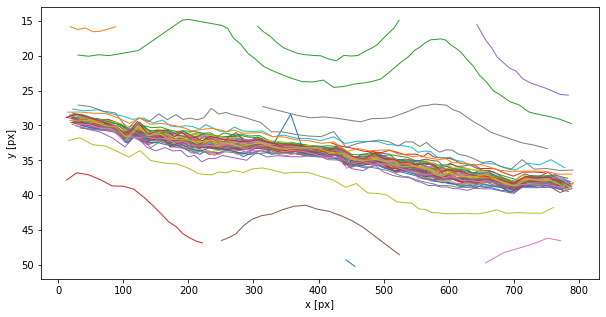

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [26]:
plt.figure()
tp.plot_traj(t)

In [27]:
t1 = tp.filter_stubs(t, 40)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 69
After: 51


In [28]:
t1_modified = t1.copy()
t1_modified['y'] = t1['y'] + crop_ys
t1_modified['x'] = t1['x'] + crop_xs
t1_modified['frame'] = t1['frame']+start_frame

In [29]:
t1_modified['particle'].unique()

array([ 0,  2,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 18, 19, 24, 25, 26,
       27, 28, 29, 30, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 61, 62, 63, 64, 65, 66, 67, 68])

Text(0.5, 0, 's')

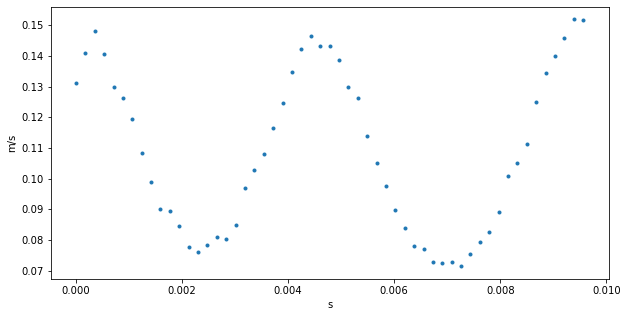

In [30]:
dt=1/framerate #s


x_pos=t1_modified[(t1_modified['particle'] == 0)]['x']
scale=10**(-6)/scale_px #um/px
v=np.gradient(x_pos,dt)*scale

# velocity in the middle of the channel
plt.plot(np.arange(0,len(x_pos))*dt,v,'.')
plt.ylabel('m/s')
plt.xlabel('s')

# Trace Particle Deformations

## velocity and stress field
for one single beads
- sanity check for edge detection and fitting algorithm
- this beads gives the velocity and rescales for the stress field

In [31]:
yloc=133
xloc=141

roi=25
parts=img_tif[100][yloc-roi:yloc+roi,xloc-roi:xloc+roi]-ref[yloc-roi:yloc+roi,xloc-roi:xloc+roi]+100
blur_parts=cv2.GaussianBlur(parts,(7,7),3)

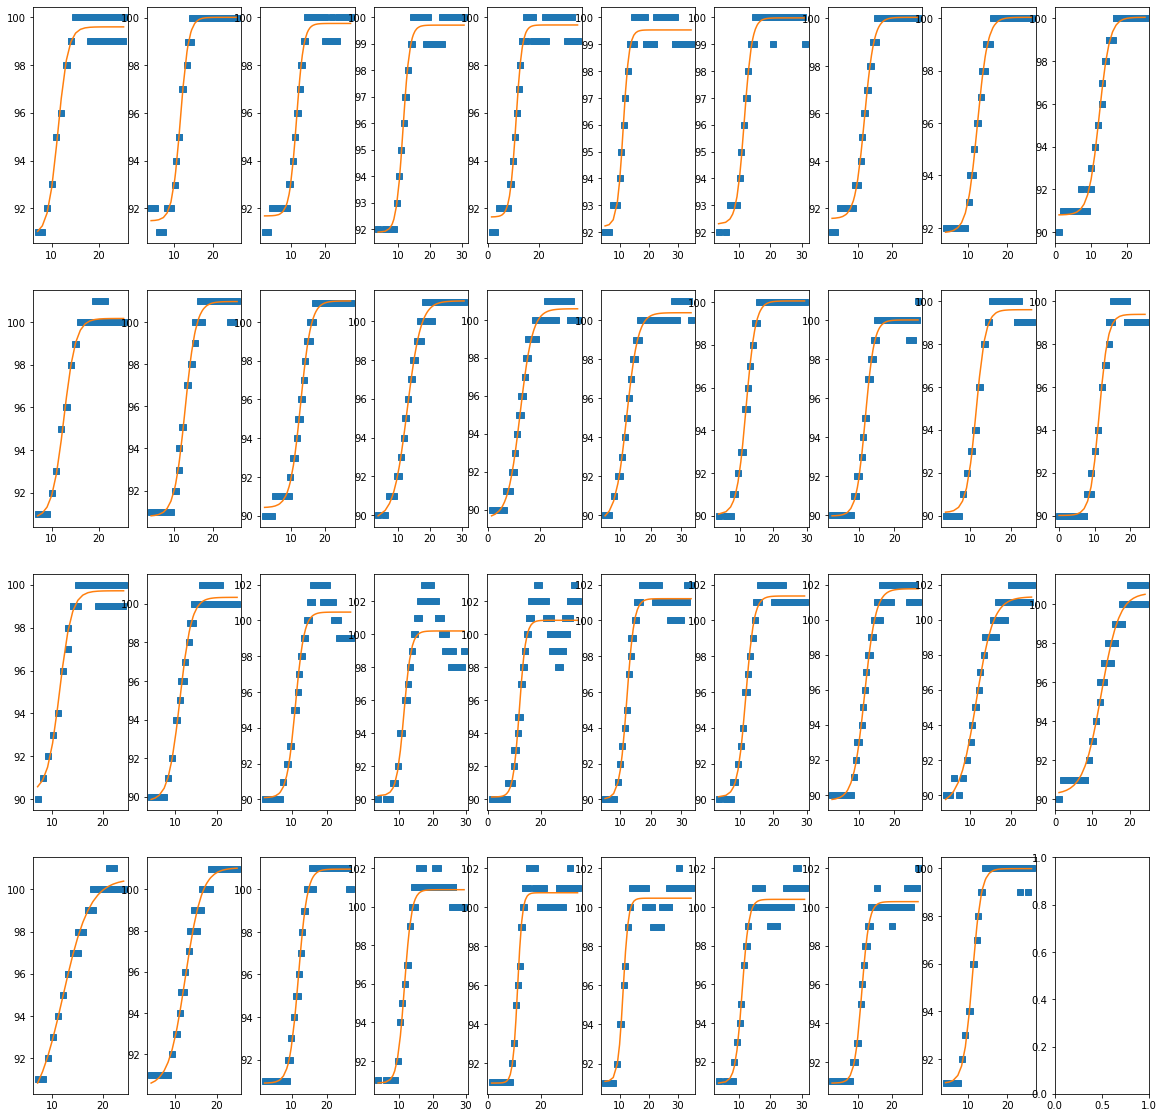

In [32]:
y_i, x_i=utils.detect_edge_sigmoid(blur_parts,roi,plot=True)

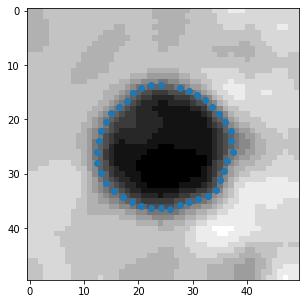

In [33]:
plt.imshow(blur_parts)
plt.plot(x_i,y_i,'o')

In [34]:
dire='/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/test/'
gamma_2 = utils.process_frames(img_tif,ref,t1_modified,0,dire)

frame number is100
frame number is101
frame number is102
frame number is103
frame number is104
frame number is105


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is106
frame number is107
frame number is108
frame number is109
frame number is110
frame number is111


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is112
frame number is113
frame number is114
frame number is115
frame number is116
frame number is117


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is118
frame number is119
frame number is120
frame number is121


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is122
frame number is123
frame number is124
frame number is125
frame number is126
frame number is127
frame number is128
frame number is129
frame number is130
frame number is131


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is132
frame number is133
frame number is134
frame number is135
frame number is136
frame number is137
frame number is138
frame number is139


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is140
frame number is141
frame number is142
frame number is143
frame number is144
frame number is145
frame number is146
frame number is147
frame number is148
frame number is149
frame number is150
frame number is151
frame number is152
frame number is153
frame number is154


### velocity

Text(0.5, 0, 's')

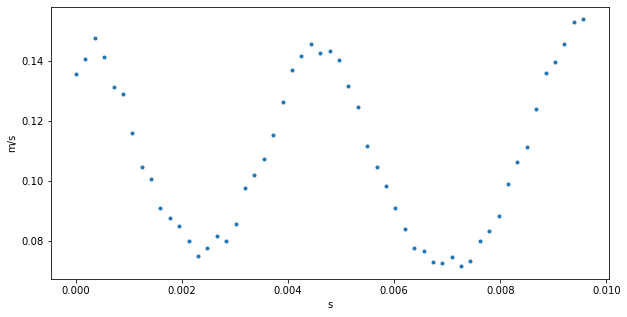

In [35]:
x_pos=t1_modified[(t1_modified['particle'] == 0)]['x']
v=np.gradient(x_pos,dt)*scale

# velocity in the middle of the channel
plt.plot(np.arange(0,len(x_pos))*dt,v,'.')
plt.ylabel('m/s')
plt.xlabel('s')

In [36]:
max_velocity=np.mean(sorted(v, reverse=True)[:3])
print(max_velocity)

0.15132418185946703


### rescale for stress field

In [37]:
real_stress=utils.calculate_stress(max_velocity)
print('The real stess amplitude in this experiment is '+str(real_stress)+' Pa.')

Q is: 5302.399332355723 ul/h
The real stess amplitude in this experiment is 18.42912357645652 Pa.


### fit for G' and G''

645.1117714480567
Storage modulus is:-699.7963966591445
Loss modulus is:1764.6994953327346
R^2: 0.021102067515717637
[0.00970777 1.19326527 0.01110195]


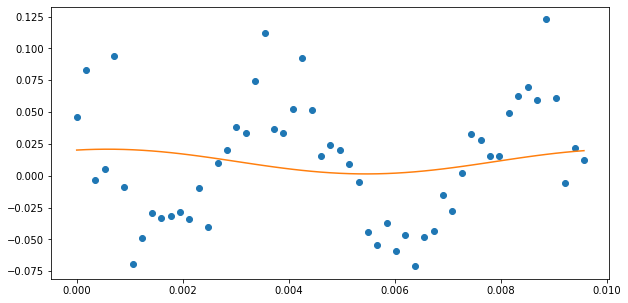

(-699.7963966591445,
 1764.6994953327346,
 645.1117714480567,
 0.021102067515717637)

In [38]:
utils.calculate_modulus(framerate,gamma_2,real_stress)

# process all beads

## wavelength 1

In [39]:
wavelength1=t1_modified[(t1_modified['x'] >= 164) & (t1_modified['x'] <= 515)]

In [40]:
wavelength1['particle'].unique()

array([ 0,  2,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 18, 19, 24, 25, 26,
       27, 28, 29, 30, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 61, 62, 63, 64, 65, 66, 67, 68])

In [41]:
gamma2list=utils.analyze_wavelength_gamma2(wavelength1,1,imgname,img_tif,ref)

particle number: 0
frame number is102
frame number is103
frame number is104
frame number is105
frame number is106


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is107
frame number is108
frame number is109


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is110
frame number is111


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is112
frame number is113
frame number is114
frame number is115
frame number is116
frame number is117


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is118
frame number is119
frame number is120
frame number is121


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is122
frame number is123
frame number is124
frame number is125
particle number: 2
frame number is148
frame number is149
frame number is150
frame number is151
frame number is152
frame number is153
frame number is154


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is155
frame number is156
frame number is157
frame number is158
frame number is159
frame number is160
frame number is161
frame number is162
frame number is163
frame number is164


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is165
frame number is166
frame number is167
frame number is168
frame number is169
frame number is170
frame number is171
frame number is172
particle number: 5
frame number is272
frame number is273
frame number is274
frame number is275
frame number is276
frame number is277
frame number is278
frame number is279


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is280
frame number is281
frame number is282
frame number is283
frame number is284
frame number is285
frame number is286
frame number is287
frame number is288
frame number is289
frame number is290
frame number is291
frame number is292
frame number is293
frame number is294


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is295
frame number is296
particle number: 6
frame number is370
frame number is371
frame number is372
frame number is373
frame number is374
frame number is375
frame number is376
frame number is377
frame number is378
frame number is379
frame number is380


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is381
frame number is382


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is383
frame number is384
frame number is385
frame number is386
frame number is387
frame number is388


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is389
frame number is390
frame number is391
frame number is392
frame number is393
frame number is394
particle number: 7
frame number is512
frame number is513
frame number is514
frame number is515
frame number is516
frame number is517
frame number is518
frame number is519
frame number is520
frame number is521


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is522
frame number is523
frame number is524
frame number is525
frame number is526
frame number is527


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is528
frame number is529
frame number is530
frame number is531
frame number is532
frame number is533
frame number is534
frame number is535
frame number is536
particle number: 8
frame number is543
frame number is544
frame number is545
frame number is546
frame number is547


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is548
frame number is549
frame number is550
frame number is551
frame number is552
frame number is553
frame number is554
frame number is555


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is556
frame number is557
frame number is558
frame number is559
frame number is560
frame number is561


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is562
frame number is563
frame number is564
frame number is565
frame number is566
particle number: 9
frame number is586


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is587
frame number is588
frame number is589
frame number is590


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is591
frame number is592
frame number is593
frame number is594
frame number is595
frame number is596
frame number is597
frame number is598
frame number is599


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is600
frame number is601
frame number is602
frame number is603
frame number is604
frame number is605


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is606
frame number is607
frame number is608
frame number is609
frame number is610
particle number: 10
frame number is602
frame number is603
frame number is604
frame number is605
frame number is606
frame number is607
frame number is608
frame number is609
frame number is610


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is611
frame number is612
frame number is613
frame number is614
frame number is615
frame number is616


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is617
frame number is618
frame number is619
frame number is620
frame number is621
frame number is622
frame number is623
frame number is624
frame number is625
frame number is626


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 11
frame number is669
frame number is670
frame number is671
frame number is672
frame number is673
frame number is674
frame number is675
frame number is676
frame number is677
frame number is678
frame number is679
frame number is680
frame number is681
frame number is682
frame number is683
frame number is684


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is685
frame number is686


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is687
frame number is688
frame number is689
frame number is690
frame number is691
frame number is692


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is693
particle number: 13
frame number is1169
frame number is1170
frame number is1171
frame number is1172
frame number is1173


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1174
frame number is1175
frame number is1176
frame number is1177
frame number is1178
frame number is1179
frame number is1180
frame number is1181
frame number is1182
frame number is1183
frame number is1184
frame number is1185


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1186
frame number is1187


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1188
frame number is1189
frame number is1190
frame number is1191
frame number is1192
frame number is1193
particle number: 14
frame number is1174
frame number is1175


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1176
frame number is1177
frame number is1178
frame number is1179


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1180
frame number is1181
frame number is1182
frame number is1183


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1184
frame number is1185
frame number is1186
frame number is1187
frame number is1188
frame number is1189
frame number is1190
frame number is1191
frame number is1192
frame number is1193
frame number is1194
frame number is1195


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1196
frame number is1197
frame number is1198
particle number: 15
frame number is1381
frame number is1382
frame number is1383
frame number is1384
frame number is1385
frame number is1386
frame number is1387
frame number is1388
frame number is1389
frame number is1390


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1391
frame number is1392
frame number is1393
frame number is1394


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1395
frame number is1396
frame number is1397
frame number is1398


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1399
frame number is1400


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1401
frame number is1402
frame number is1403
frame number is1404
frame number is1405
particle number: 18
frame number is1818


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1819
frame number is1820
frame number is1821
frame number is1822
frame number is1823
frame number is1824
frame number is1825
frame number is1826


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1827
frame number is1828
frame number is1829
frame number is1830
frame number is1831
frame number is1832
frame number is1833
frame number is1834


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1835
frame number is1836
frame number is1837
frame number is1838
frame number is1839
frame number is1840
frame number is1841
frame number is1842


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 19
frame number is1976
frame number is1977
frame number is1978
frame number is1979
frame number is1980
frame number is1981


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1982
frame number is1983
frame number is1984
frame number is1985


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1986
frame number is1987


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1988
frame number is1989
frame number is1990
frame number is1991


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1992
frame number is1993
frame number is1994
frame number is1995
frame number is1996
frame number is1997
frame number is1998
frame number is1999


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 24
frame number is2209
frame number is2210
frame number is2211


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2212
frame number is2213


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2214
frame number is2215
frame number is2216
frame number is2217


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2218
frame number is2219


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2220
frame number is2221
frame number is2222
frame number is2223


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2224
frame number is2225
frame number is2226
frame number is2227
frame number is2228
frame number is2229


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2230
frame number is2231
frame number is2232
frame number is2233


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 25
frame number is2339
frame number is2340
frame number is2341
frame number is2342


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2343
frame number is2344


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2345
frame number is2346


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2347
frame number is2348
frame number is2349
frame number is2350


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2351
frame number is2352


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2353
frame number is2354
frame number is2355
frame number is2356


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2357
frame number is2358
frame number is2359
frame number is2360
frame number is2361
frame number is2362
particle number: 26
frame number is2357
frame number is2358
frame number is2359
frame number is2360
frame number is2361
frame number is2362


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2363
frame number is2364


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2365
frame number is2366


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2367
frame number is2368
frame number is2369
frame number is2370


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2371
frame number is2372


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2373
frame number is2374


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2375
frame number is2376
frame number is2377
frame number is2378
frame number is2379
frame number is2380
particle number: 27
frame number is2549
frame number is2550


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2551
frame number is2552


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2553
frame number is2554


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2555
frame number is2556
frame number is2557
frame number is2558
frame number is2559
frame number is2560
frame number is2561
frame number is2562


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2563
frame number is2564


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2565
frame number is2566
frame number is2567
frame number is2568
frame number is2569
frame number is2570
frame number is2571
frame number is2572
particle number: 28
frame number is2578
frame number is2579
frame number is2580
frame number is2581


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2582
frame number is2583
frame number is2584
frame number is2585


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2586
frame number is2587
frame number is2588
frame number is2589
frame number is2590
frame number is2591


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2592
frame number is2593


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2594
frame number is2595
frame number is2596
frame number is2597


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2598
frame number is2599
frame number is2600
frame number is2601
frame number is2602
particle number: 29
frame number is2607
frame number is2608
frame number is2609
frame number is2610
frame number is2611
frame number is2612
frame number is2613
frame number is2614
frame number is2615


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2616
frame number is2617
frame number is2618
frame number is2619


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2620
frame number is2621


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2622
frame number is2623
frame number is2624
frame number is2625
frame number is2626
frame number is2627
frame number is2628
frame number is2629
frame number is2630
particle number: 30
frame number is2660
frame number is2661
frame number is2662
frame number is2663
frame number is2664


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2665
frame number is2666
frame number is2667
frame number is2668


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2669
frame number is2670
frame number is2671
frame number is2672


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2673
frame number is2674
frame number is2675
frame number is2676
frame number is2677
frame number is2678
frame number is2679
frame number is2680
frame number is2681
frame number is2682
frame number is2683
particle number: 37
frame number is2841
frame number is2842
frame number is2843
frame number is2844
frame number is2845
frame number is2846
frame number is2847
frame number is2848
frame number is2849
frame number is2850
frame number is2851


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2852
frame number is2853
frame number is2854
frame number is2855


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2856
frame number is2857
frame number is2858
frame number is2859


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2860
frame number is2861
frame number is2862
frame number is2863
frame number is2864
particle number: 38
frame number is2877


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2878
frame number is2879


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2880
frame number is2881
frame number is2882
frame number is2883
frame number is2884
frame number is2885
frame number is2886
frame number is2887
frame number is2888
frame number is2889


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2890
frame number is2891
frame number is2892
frame number is2893
frame number is2894
frame number is2895
frame number is2896
frame number is2897
frame number is2898
frame number is2899
frame number is2900
frame number is2901


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 39
frame number is3396
frame number is3397
frame number is3398
frame number is3399
frame number is3400
frame number is3401
frame number is3402
frame number is3403
frame number is3404
frame number is3405
frame number is3406
frame number is3407
frame number is3408
frame number is3409
frame number is3410
frame number is3411
frame number is3412
frame number is3413
frame number is3414
frame number is3415
frame number is3416
frame number is3417
frame number is3418
frame number is3419
particle number: 40
frame number is3431
frame number is3432


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3433
frame number is3434
frame number is3435
frame number is3436
frame number is3437
frame number is3438
frame number is3439
frame number is3440


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3441
frame number is3442
frame number is3443
frame number is3444
frame number is3445
frame number is3446


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3447
frame number is3448


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3449
frame number is3450


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3451
frame number is3452
frame number is3453
frame number is3454
frame number is3455
particle number: 41
frame number is3577
frame number is3578
frame number is3579
frame number is3580
frame number is3581
frame number is3582
frame number is3583
frame number is3584
frame number is3585
frame number is3586
frame number is3587
frame number is3588
frame number is3589
frame number is3590
frame number is3591
frame number is3592
frame number is3593
frame number is3594
frame number is3595


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3596
frame number is3597
frame number is3598
frame number is3599
frame number is3600
frame number is3601
particle number: 42
frame number is3631
frame number is3632
frame number is3633
frame number is3634
frame number is3635
frame number is3636


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3637
frame number is3638


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3639
frame number is3640
frame number is3641
frame number is3642
frame number is3643
frame number is3644
frame number is3645
frame number is3646


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3647
frame number is3648
frame number is3649
frame number is3650


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3651
frame number is3652
frame number is3653
frame number is3654
particle number: 43
frame number is4055
frame number is4056
frame number is4057
frame number is4058
frame number is4059
frame number is4060


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4061
frame number is4062
frame number is4063
frame number is4064
frame number is4065
frame number is4066
frame number is4067
frame number is4068


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4069
frame number is4070
frame number is4071
frame number is4072
frame number is4073
frame number is4074
frame number is4075
frame number is4076


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4077
frame number is4078


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 44
frame number is4092
frame number is4093
frame number is4094
frame number is4095
frame number is4096
frame number is4097


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4098
frame number is4099


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4100
frame number is4101
frame number is4102
frame number is4103
frame number is4104
frame number is4105


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4106
frame number is4107


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4108
frame number is4109
frame number is4110
frame number is4111


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4112
frame number is4113
frame number is4114
frame number is4115
particle number: 45
frame number is4174
frame number is4175
frame number is4176
frame number is4177
frame number is4178
frame number is4179
frame number is4180
frame number is4181
frame number is4182
frame number is4183
frame number is4184
frame number is4185
frame number is4186
frame number is4187


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4188
frame number is4189
frame number is4190
frame number is4191
frame number is4192


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4193
frame number is4194


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4195
frame number is4196
frame number is4197
particle number: 46
frame number is4340
frame number is4341
frame number is4342
frame number is4343
frame number is4344
frame number is4345
frame number is4346
frame number is4347
frame number is4348
frame number is4349
frame number is4350
frame number is4351
frame number is4352
frame number is4353
frame number is4354
frame number is4355
frame number is4356
frame number is4358
frame number is4359


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4360
frame number is4361
frame number is4362
frame number is4363
particle number: 47
frame number is4596
frame number is4597


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4598
frame number is4599


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4600
frame number is4601
frame number is4602
frame number is4603


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4604
frame number is4605


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4606
frame number is4607


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4608
frame number is4609


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4610
frame number is4611


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4612
frame number is4613


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4614
frame number is4615


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4616
frame number is4617


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4618
frame number is4619


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 48
frame number is4608
frame number is4609
frame number is4610
frame number is4611
frame number is4612
frame number is4613


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4614
frame number is4615
frame number is4616
frame number is4617


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4618
frame number is4619


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4620
frame number is4621
frame number is4622
frame number is4623
frame number is4624
frame number is4625


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4626
frame number is4627
frame number is4628
frame number is4629
frame number is4630
frame number is4631
frame number is4632
particle number: 49
frame number is4768
frame number is4769
frame number is4770


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4771
frame number is4772
frame number is4773
frame number is4774


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4775
frame number is4776
frame number is4777
frame number is4778


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4779
frame number is4780


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4781
frame number is4782


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4783
frame number is4784


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4785
frame number is4786
frame number is4787
frame number is4788
frame number is4789
frame number is4790
frame number is4791
particle number: 50
frame number is4841
frame number is4842
frame number is4843
frame number is4844
frame number is4845
frame number is4846
frame number is4847
frame number is4848
frame number is4849
frame number is4850
frame number is4851
frame number is4852
frame number is4853
frame number is4854
frame number is4858
frame number is4860
frame number is4862


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4863
frame number is4864
particle number: 51
frame number is5322
frame number is5323
frame number is5324
frame number is5325
frame number is5326
frame number is5327
frame number is5328
frame number is5329
frame number is5330
frame number is5331


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5332
frame number is5333
frame number is5334
frame number is5335


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5336
frame number is5337


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5338
frame number is5339
frame number is5340
frame number is5341


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5342
frame number is5343
frame number is5344
frame number is5345


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5346
particle number: 52
frame number is5552


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5553
frame number is5556
frame number is5562


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5563


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5569
frame number is5570


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5571
frame number is5572
frame number is5573


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5574
frame number is5575


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5576
frame number is5577


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5578
frame number is5579


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5580
particle number: 53
frame number is5581
frame number is5582
frame number is5583
frame number is5584
frame number is5585
frame number is5586
frame number is5587
frame number is5588
frame number is5589
frame number is5590
frame number is5591
frame number is5592
frame number is5593
frame number is5594
frame number is5595


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5596
frame number is5597
frame number is5598
frame number is5599
frame number is5600


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5601
frame number is5602


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5603
frame number is5604
particle number: 54
frame number is5664
frame number is5665


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5666
frame number is5667
frame number is5668
frame number is5669


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5670
frame number is5671
frame number is5672
frame number is5673


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5674
frame number is5675


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5676
frame number is5677
frame number is5678
frame number is5679
frame number is5681
frame number is5682


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5683
frame number is5684


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5685
frame number is5686
frame number is5687
particle number: 55
frame number is5757


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5758
frame number is5759
frame number is5760
frame number is5761
frame number is5762
frame number is5763
frame number is5764
frame number is5765


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5766
frame number is5767
frame number is5768
frame number is5769
frame number is5770
frame number is5771
frame number is5772
frame number is5773


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5774
frame number is5775
frame number is5776
frame number is5777
frame number is5778
frame number is5779
frame number is5780
particle number: 56
frame number is6100


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6101
frame number is6102
frame number is6103
frame number is6104


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6105
frame number is6106
frame number is6107
frame number is6108


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6109
frame number is6110
frame number is6111
frame number is6112


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6113
frame number is6114
frame number is6115
frame number is6116
frame number is6117
frame number is6118
frame number is6119
frame number is6120
frame number is6121
frame number is6122
frame number is6123
frame number is6124
particle number: 57
frame number is6127
frame number is6128
frame number is6129
frame number is6130
frame number is6131
frame number is6132
frame number is6133
frame number is6134
frame number is6135
frame number is6136


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6137
frame number is6138
frame number is6139
frame number is6140
frame number is6141
frame number is6142
frame number is6143
frame number is6144
frame number is6145
frame number is6146
frame number is6147
frame number is6148
frame number is6149
frame number is6150


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 58
frame number is6146
frame number is6147
frame number is6148
frame number is6149


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6150
frame number is6151
frame number is6152
frame number is6153
frame number is6154
frame number is6155


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6156
frame number is6157


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6158
frame number is6159


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6160
frame number is6161
frame number is6162
frame number is6163
frame number is6164
frame number is6165
frame number is6166
frame number is6167
frame number is6168
frame number is6169


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 61
frame number is6232
frame number is6233
frame number is6234
frame number is6235
frame number is6236
frame number is6237
frame number is6238
frame number is6239
frame number is6240
frame number is6241


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6242
frame number is6243
frame number is6244
frame number is6245


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6246
frame number is6247
frame number is6248
frame number is6249
frame number is6250
frame number is6251


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6252
frame number is6253
frame number is6254
frame number is6255
particle number: 62
frame number is6304
frame number is6305


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6306
frame number is6307
frame number is6308
frame number is6309


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6310
frame number is6311
frame number is6312
frame number is6313
frame number is6314
frame number is6315
frame number is6316
frame number is6317


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6318
frame number is6319
frame number is6320
frame number is6321
frame number is6322
frame number is6323
frame number is6324
frame number is6325
frame number is6326
frame number is6327


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6328
particle number: 63
frame number is6340
frame number is6341
frame number is6342
frame number is6343
frame number is6344
frame number is6345
frame number is6346
frame number is6347
frame number is6348
frame number is6349
frame number is6350
frame number is6351
frame number is6352
frame number is6353
frame number is6354


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6355
frame number is6356
frame number is6357
frame number is6358
frame number is6359
frame number is6360
frame number is6361
frame number is6362


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6363
particle number: 64
frame number is6455
frame number is6456
frame number is6457
frame number is6458
frame number is6459
frame number is6460
frame number is6461


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6462
frame number is6463


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6464
frame number is6465
frame number is6466
frame number is6467
frame number is6468
frame number is6469
frame number is6470
frame number is6471
frame number is6472
frame number is6473
frame number is6474
frame number is6475
frame number is6476
frame number is6477
frame number is6478
particle number: 65
frame number is6508


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6509
frame number is6510
frame number is6511
frame number is6512
frame number is6513
frame number is6514
frame number is6515
frame number is6516
frame number is6517
frame number is6518
frame number is6519
frame number is6520
frame number is6521
frame number is6522
frame number is6523


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6524
frame number is6525


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6526
frame number is6527
frame number is6528
frame number is6529
frame number is6530
frame number is6531


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 66
frame number is6619
frame number is6620
frame number is6621


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6622
frame number is6623
frame number is6624
frame number is6625


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6626
frame number is6627


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6628
frame number is6629
frame number is6630
frame number is6631
frame number is6632
frame number is6633


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6634
frame number is6635


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6636
frame number is6637
frame number is6638
frame number is6639


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6640
frame number is6641
frame number is6642
particle number: 67
frame number is6814


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6815
frame number is6816
frame number is6817
frame number is6818
frame number is6819
frame number is6820
frame number is6821
frame number is6822
frame number is6823
frame number is6824
frame number is6825
frame number is6826
frame number is6827
frame number is6828
frame number is6829
frame number is6830
frame number is6831
frame number is6832
frame number is6833
frame number is6834
frame number is6835
frame number is6836
frame number is6837
particle number: 68
frame number is6921
frame number is6922
frame number is6923
frame number is6924
frame number is6925
frame number is6926
frame number is6927
frame number is6928
frame number is6929


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6930
frame number is6931


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6932
frame number is6933


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6934
frame number is6935
frame number is6936
frame number is6937
frame number is6938
frame number is6939
frame number is6940
frame number is6941
frame number is6942
frame number is6943
frame number is6944
frame number is6945


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


In [42]:
with open(imgname+'gamma2.pkl', 'wb') as f:
    pickle.dump(gamma2list, f)

particle is:0
1478.381142901797
Storage modulus is:311.58711905887816
Loss modulus is:140.4580041232283
R^2: 0.6529476716164704
[0.05392069 2.71808823 0.01406671]


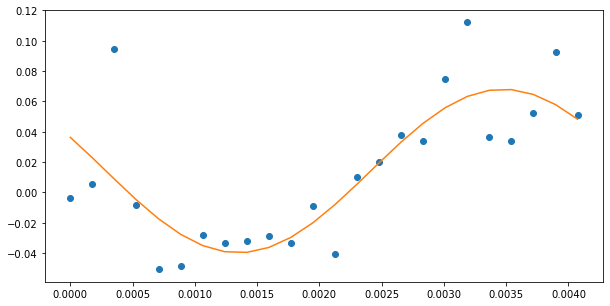

particle is:2
1419.245897185725
Storage modulus is:276.24469567517184
Loss modulus is:77.24164886959107
R^2: 0.8138900947863831
[0.06424871 2.86894271 0.01594436]


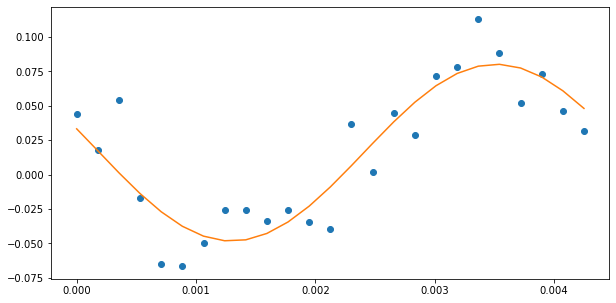

particle is:5
1419.245897185725
Storage modulus is:169.9232436193747
Loss modulus is:185.50393577376374
R^2: 0.7217474724034143
[0.07325751 2.31238601 0.04738417]


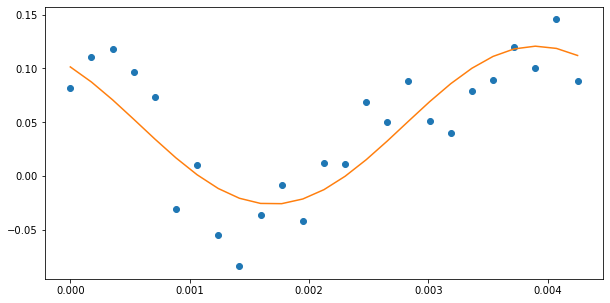

particle is:6
1419.245897185725
Storage modulus is:260.7454355951675
Loss modulus is:207.40342649901723
R^2: 0.8407091868670904
[0.05531395 2.46964761 0.0060554 ]


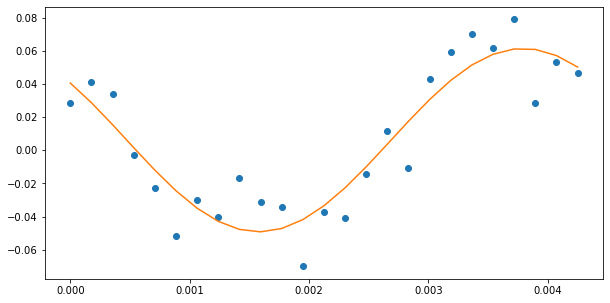

particle is:7
1419.245897185725
Storage modulus is:353.8880667318942
Loss modulus is:188.51686864272634
R^2: 0.828831018906672
[0.04596158 2.65212701 0.01362869]


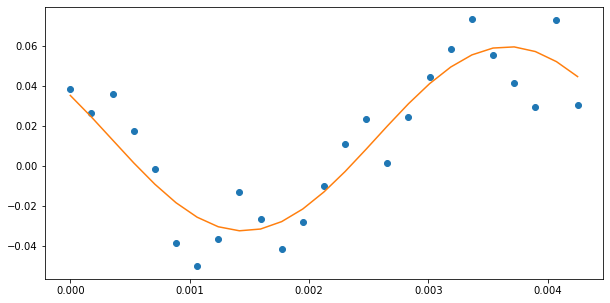

particle is:8
1478.381142901797
Storage modulus is:273.4562748502153
Loss modulus is:92.42553950016077
R^2: 0.7657255188119539
[ 0.06384515  2.8156568  -0.01296109]


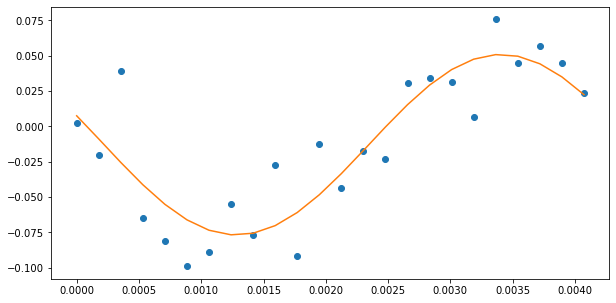

particle is:9
1419.245897185725
Storage modulus is:339.21391247182635
Loss modulus is:146.58643569676616
R^2: 0.6387235467029492
[ 0.04987157  2.73369358 -0.00336202]


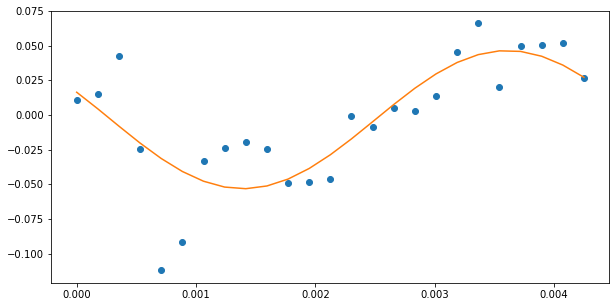

particle is:10
1419.245897185725
Storage modulus is:298.91242985787454
Loss modulus is:151.57035926612164
R^2: 0.8461375016191438
[0.0549885  2.67230284 0.0030881 ]


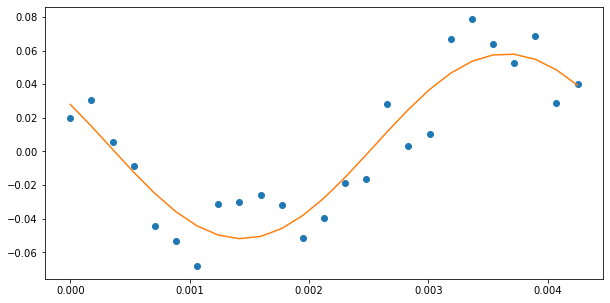

particle is:11
1419.245897185725
Storage modulus is:264.57269920497083
Loss modulus is:160.78896116333996
R^2: 0.7186413570673028
[ 0.0595257   2.59550817 -0.0182831 ]


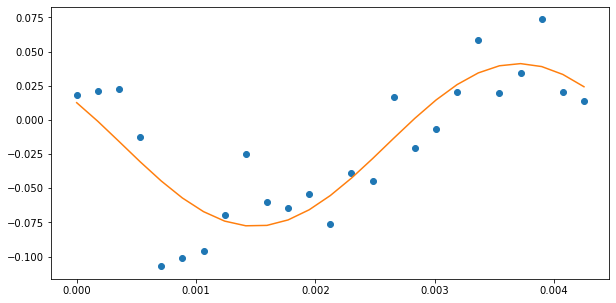

particle is:13
1419.245897185725
Storage modulus is:313.9145206818381
Loss modulus is:102.00336610365551
R^2: 0.8985933405329052
[ 5.58337784e-02  2.82741508e+00 -7.87085936e-05]


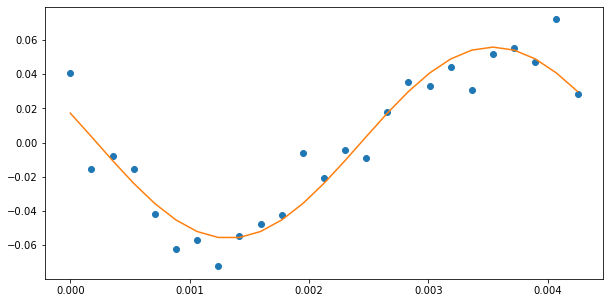

particle is:14
1419.245897185725
Storage modulus is:341.27292271146894
Loss modulus is:109.83820776858272
R^2: 0.7736091551229072
[0.05140432 2.83021374 0.00424779]


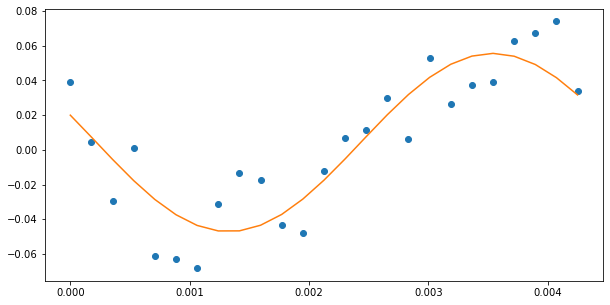

particle is:15
1419.245897185725
Storage modulus is:221.67746427292855
Loss modulus is:70.76463196947876
R^2: 0.888820231745624
[ 0.07919748  2.83259434 -0.00651819]


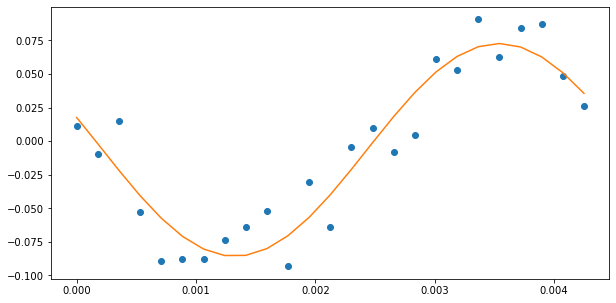

particle is:18
1419.245897185725
Storage modulus is:317.9584384955606
Loss modulus is:59.91710016062361
R^2: 0.8224972031853197
[ 5.69582980e-02  2.95533371e+00 -1.27123489e-03]


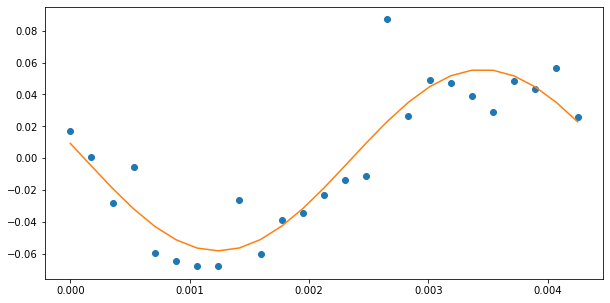

particle is:19
1478.381142901797
Storage modulus is:324.4756968944155
Loss modulus is:98.12284113507768
R^2: 0.7982002913613641
[ 0.05436519  2.84793156 -0.01147145]


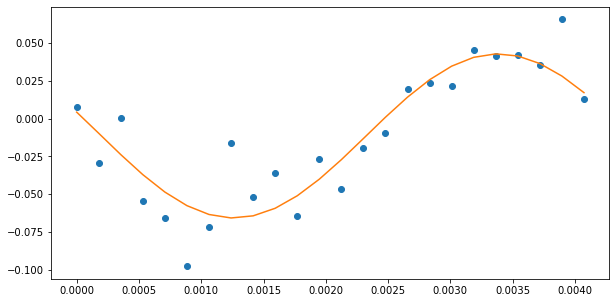

particle is:24
1419.245897185725
Storage modulus is:282.24027088087644
Loss modulus is:148.7798351347727
R^2: 0.8349460146217592
[ 0.0577619   2.65647036 -0.00367856]


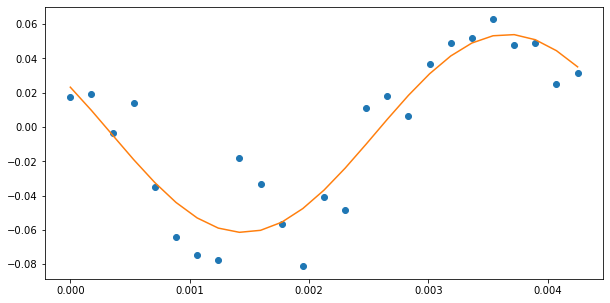

particle is:25
1478.381142901797
Storage modulus is:289.2318917965032
Loss modulus is:83.06191638393528
R^2: 0.8432384614589167
[0.06124209 2.86193746 0.00510915]


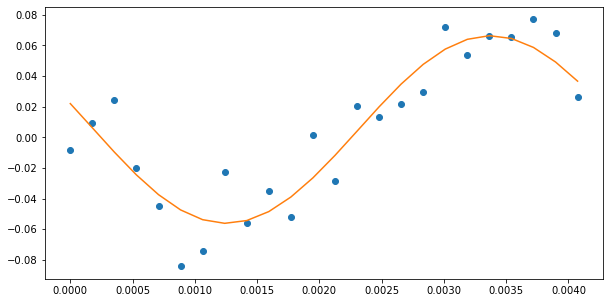

particle is:26
1478.381142901797
Storage modulus is:263.2871859308505
Loss modulus is:98.93627509146795
R^2: 0.8448444003779138
[0.06552289 2.78214426 0.02044437]


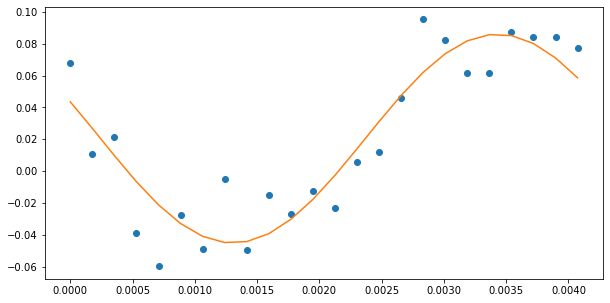

particle is:27
1478.381142901797
Storage modulus is:254.67357257480936
Loss modulus is:146.8665834725452
R^2: 0.8689942647148565
[6.26868418e-02 2.61849252e+00 2.59724275e-03]


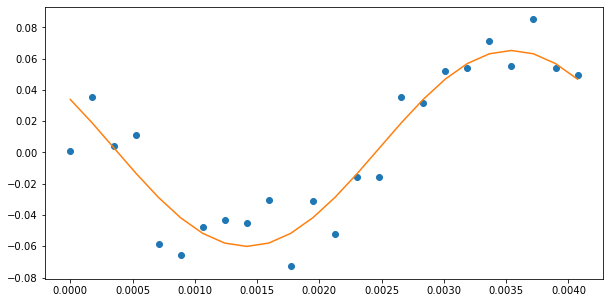

particle is:28
1419.245897185725
Storage modulus is:296.33762822121037
Loss modulus is:211.73761741274024
R^2: 0.724732532567599
[5.06002900e-02 2.52119150e+00 2.13185455e-03]


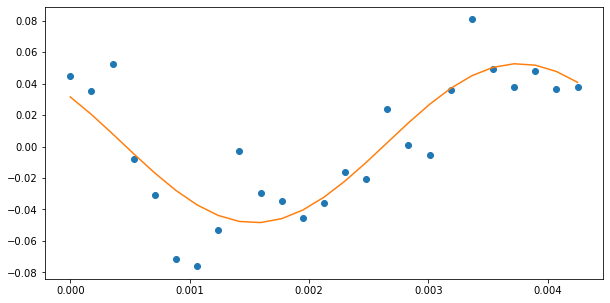

particle is:29
1478.381142901797
Storage modulus is:334.4066532697248
Loss modulus is:88.01972079216118
R^2: 0.7638429175485961
[0.05329469 2.88421868 0.00864569]


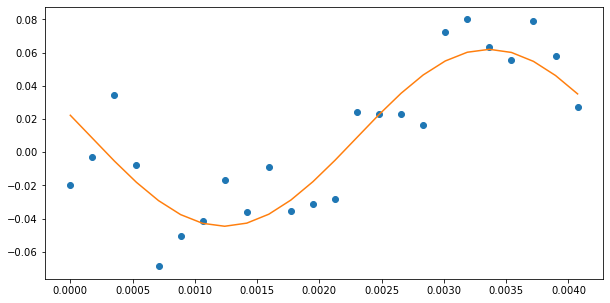

particle is:30
1478.381142901797
Storage modulus is:357.5456817206116
Loss modulus is:36.17567221653299
R^2: 0.7897823727138149
[0.05128159 3.04075804 0.00558987]


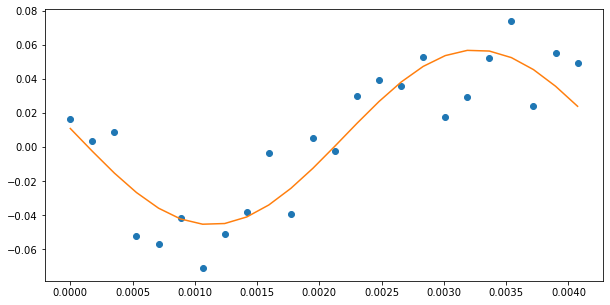

particle is:37
1478.381142901797
Storage modulus is:346.4542106928216
Loss modulus is:189.80583810432728
R^2: 0.7092429255048252
[ 0.04665126  2.64039962 -0.00680906]


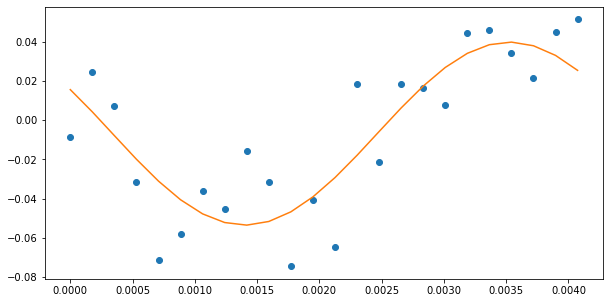

particle is:38
1419.245897185725
Storage modulus is:292.7474272596787
Loss modulus is:98.73874083557351
R^2: 0.8926085976173475
[0.05965074 2.81629159 0.0061002 ]


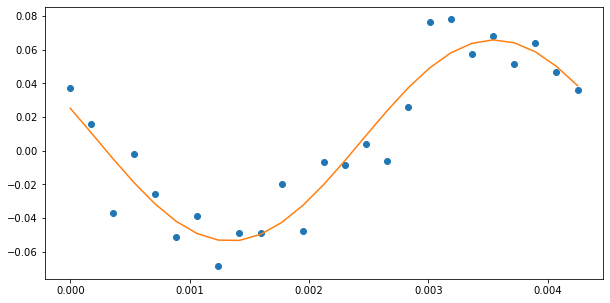

particle is:39
1478.381142901797
Storage modulus is:283.907686461178
Loss modulus is:107.77729551088798
R^2: 0.8013492889135122
[ 0.06068666  2.77877694 -0.00352529]


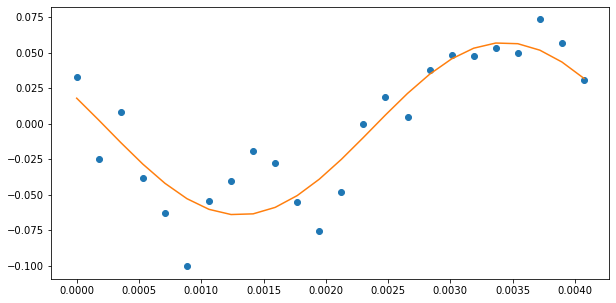

particle is:40
1419.245897185725
Storage modulus is:389.2153842559472
Loss modulus is:112.35879126537701
R^2: 0.7110883778019981
[0.04549179 2.86055304 0.00502105]


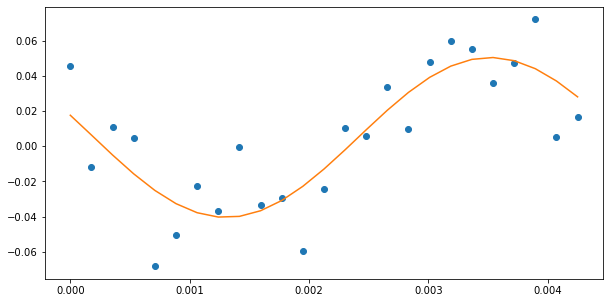

particle is:41
1419.245897185725
Storage modulus is:302.6137147135628
Loss modulus is:179.0746976901309
R^2: 0.8137641566794626
[0.05241074 2.60725399 0.00271864]


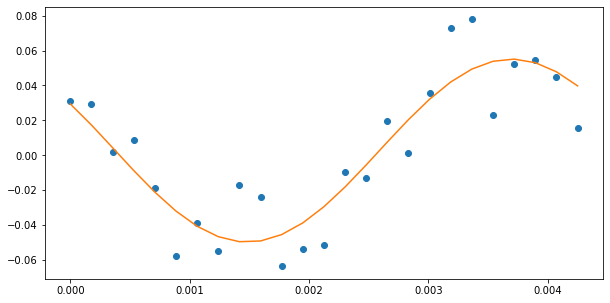

particle is:42
1478.381142901797
Storage modulus is:238.31078165672753
Loss modulus is:205.41781908786783
R^2: 0.8293198716385852
[0.058575   2.43018772 0.01306632]


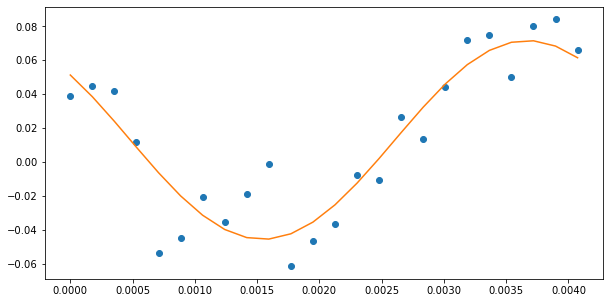

particle is:43
1478.381142901797
Storage modulus is:224.18475165475417
Loss modulus is:147.71216091387365
R^2: 0.8570833085623113
[ 0.06864427  2.55899613 -0.03185328]


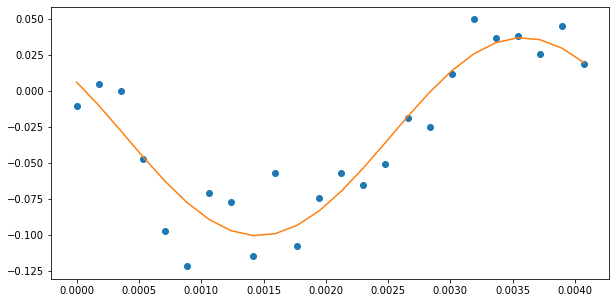

particle is:44
1478.381142901797
Storage modulus is:322.64704020845966
Loss modulus is:150.46814550937336
R^2: 0.845226779273836
[ 0.05176602  2.70522124 -0.01578098]


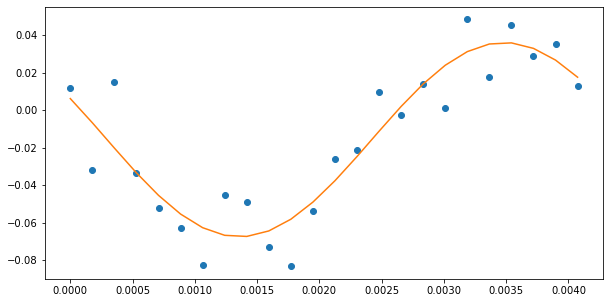

particle is:45
1478.381142901797
Storage modulus is:181.93748819639174
Loss modulus is:112.08452758416871
R^2: 0.8376373120680937
[0.0862416  2.58944747 0.08980713]


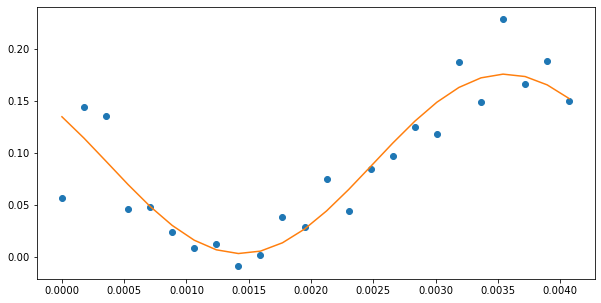

particle is:46
1542.6585838975273
Storage modulus is:267.7359963073309
Loss modulus is:129.41334007805324
R^2: 0.8710526439488787
[ 0.0619732   2.69134402 -0.00701233]


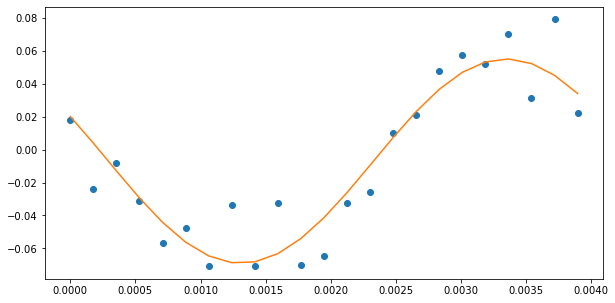

particle is:47
1478.381142901797
Storage modulus is:232.3280876339265
Loss modulus is:1290.510510056203
R^2: 0.09122034850177685
[1.40545523e-02 1.74891643e+00 5.98583686e-04]


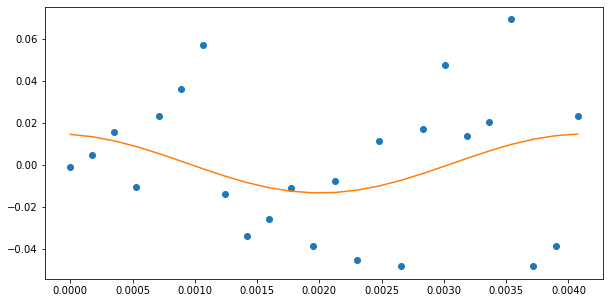

particle is:48
1419.245897185725
Storage modulus is:359.0405663624101
Loss modulus is:107.18308678225587
R^2: 0.8434258111171722
[0.04918398 2.85148834 0.0197378 ]


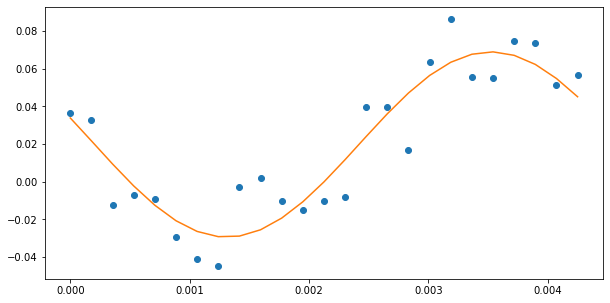

particle is:49
1478.381142901797
Storage modulus is:325.0175320761971
Loss modulus is:174.45694969952027
R^2: 0.7254621375297732
[ 0.04995982  2.64897002 -0.01984864]


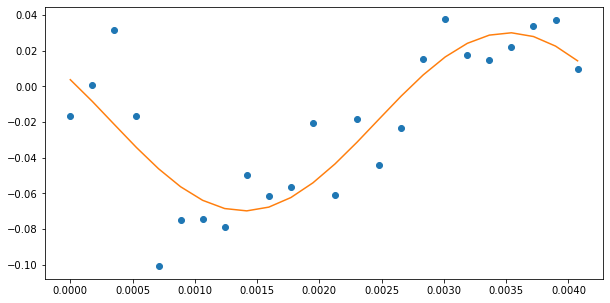

particle is:50
1867.4288120864803
Storage modulus is:435.5885783985739
Loss modulus is:162.98963266652441
R^2: 0.7346986172204766
[ 0.03962537  2.78353887 -0.0136818 ]


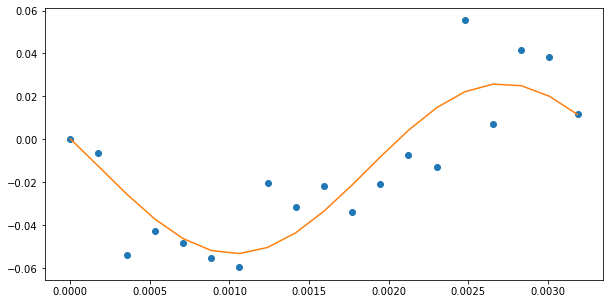

particle is:51
1419.245897185725
Storage modulus is:297.6416773217935
Loss modulus is:103.44471703458667
R^2: 0.8895274732647133
[0.0584856  2.80710407 0.01173362]


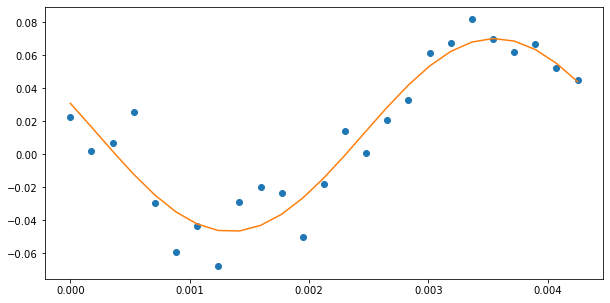

particle is:52
2087.126319390772
Storage modulus is:719.2108438653268
Loss modulus is:259.38802334915084
R^2: 0.045434020011246856
[0.02410434 2.79545607 0.04335084]


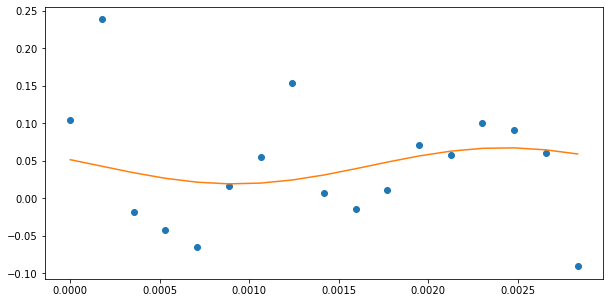

particle is:53
1478.381142901797
Storage modulus is:292.52085616759217
Loss modulus is:153.27904753473234
R^2: 0.8573989512825685
[ 5.58041023e-02  2.65893495e+00 -8.61727242e-04]


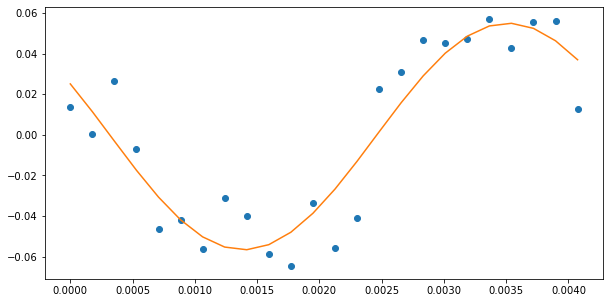

particle is:54
1542.6585838975273
Storage modulus is:11.704046798878391
Loss modulus is:551.19626845891
R^2: -2.197203642641309
[ 0.03342724  1.59202704 -0.1       ]


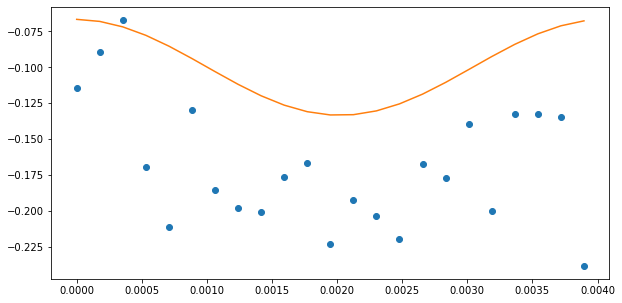

particle is:55
1478.381142901797
Storage modulus is:294.1485046357307
Loss modulus is:153.7673534798896
R^2: 0.5853414092416911
[ 0.05552358  2.65990786 -0.0027539 ]


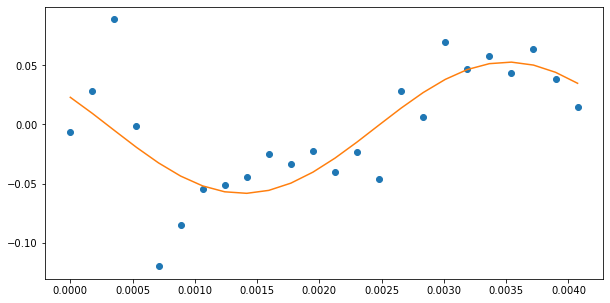

particle is:56
1419.245897185725
Storage modulus is:249.5626179886379
Loss modulus is:158.99838728211088
R^2: 0.8443314210268696
[ 0.06227975  2.57433367 -0.00322835]


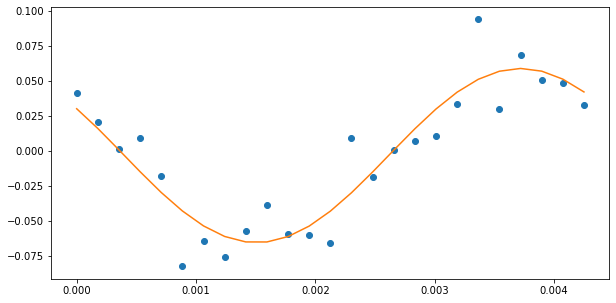

particle is:57
1478.381142901797
Storage modulus is:197.95270800579786
Loss modulus is:141.05078065505046
R^2: 0.7254782495857575
[ 0.07581973  2.52249485 -0.02544089]


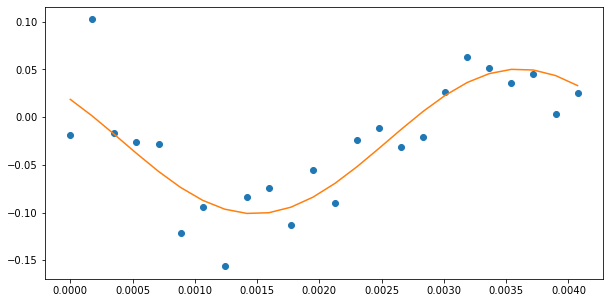

particle is:58
1478.381142901797
Storage modulus is:153.11588847791555
Loss modulus is:201.5591758622144
R^2: 0.893279361487705
[0.07280737 2.22044948 0.07582982]


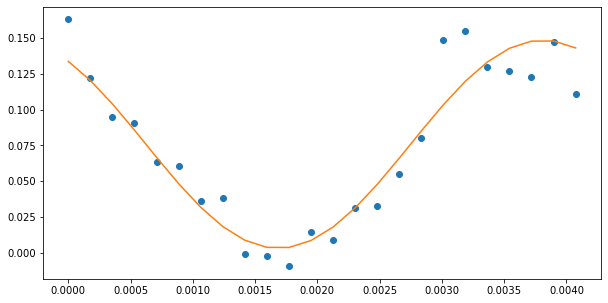

particle is:61
1478.381142901797
Storage modulus is:371.7903993870748
Loss modulus is:190.9136768546906
R^2: 0.6429994619959447
[0.04409485 2.66720494 0.03226791]


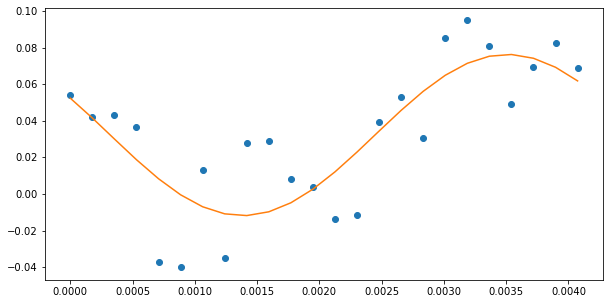

particle is:62
1419.245897185725
Storage modulus is:282.20900510759805
Loss modulus is:87.92766047918599
R^2: 0.7947171593802405
[0.062347   2.83955591 0.01199439]


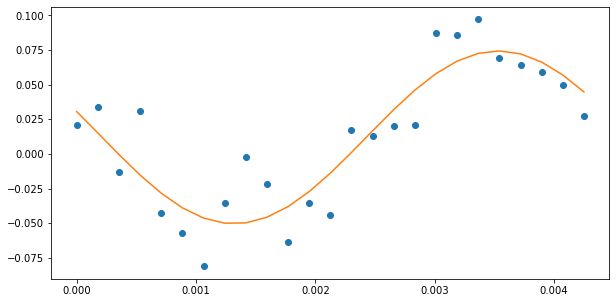

particle is:63
1478.381142901797
Storage modulus is:284.5346755227528
Loss modulus is:88.7980058001725
R^2: 0.8305646365000104
[0.0618284  2.83908911 0.00388799]


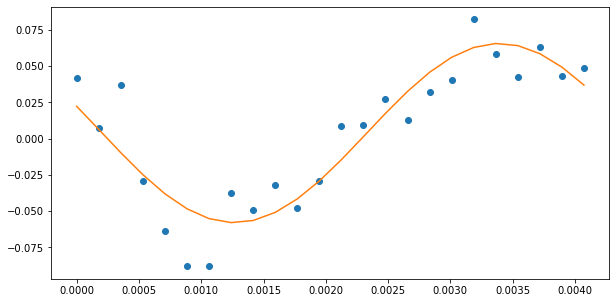

particle is:64
1478.381142901797
Storage modulus is:316.08798979055206
Loss modulus is:116.09200555326353
R^2: 0.741533423414809
[ 0.05472922  2.78960953 -0.01184867]


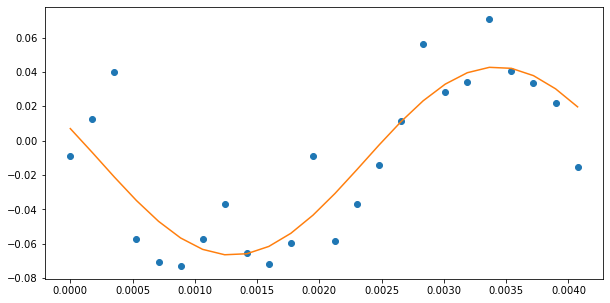

particle is:65
1478.381142901797
Storage modulus is:299.3058171110071
Loss modulus is:97.38053021352748
R^2: 0.7507161698275467
[0.05855181 2.82704005 0.01195276]


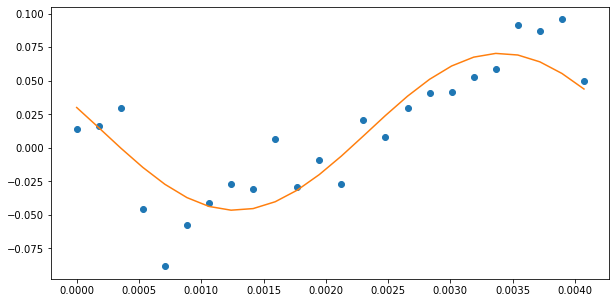

particle is:66
2087.126319390772
Storage modulus is:-299.31645611853804
Loss modulus is:3.665569399176968e-14
R^2: 0.05251906321631017
[ 6.15706995e-02  3.56582832e-17 -8.78476214e-03]


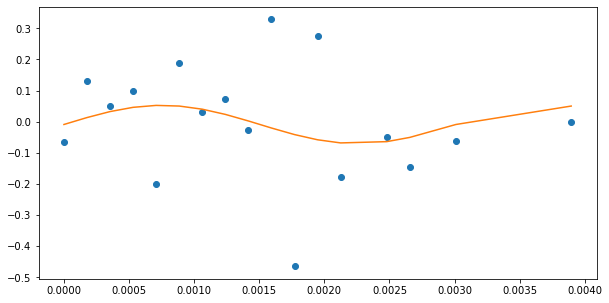

particle is:67
1478.381142901797
Storage modulus is:347.148344807239
Loss modulus is:104.66531823408096
R^2: 0.7712199968618598
[ 0.05082725  2.84876004 -0.00481855]


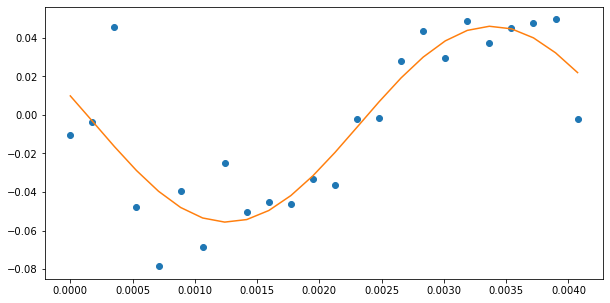

particle is:68
1419.245897185725
Storage modulus is:258.1231823126491
Loss modulus is:161.11583572301217
R^2: 0.8610532423383132
[6.05664724e-02 2.58358180e+00 7.42420822e-04]


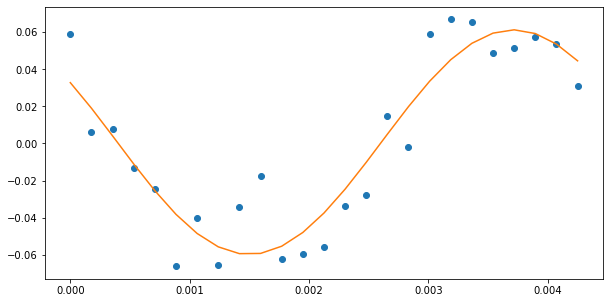

In [43]:
data1=utils.analyze_wavelength_modulus(wavelength1,gamma2list,real_stress,framerate,imgname)

In [44]:
data1

,Droplet Number,Storage Modulus,Loss Modulus,Frequency,R^2,Video Name
1,2,276.244696,77.241649,1419.245897,0.813890,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...
3,6,260.745436,207.403426,1419.245897,0.840709,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...
4,7,353.888067,188.516869,1419.245897,0.828831,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...
7,10,298.912430,151.570359,1419.245897,0.846138,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...
9,13,313.914521,102.003366,1419.245897,0.898593,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...
11,15,221.677464,70.764632,1419.245897,0.888820,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...
12,18,317.958438,59.917100,1419.245897,0.822497,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...
14,24,282.240271,148.779835,1419.245897,0.834946,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...
15,25,289.231892,83.061916,1478.381143,0.843238,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...
16,26,263.287186,98.936275,1478.381143,0.844844,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...


## wavelegnth 2

In [45]:
wavelength2=t1_modified[(t1_modified['x'] >= 515) & (t1_modified['x'] <= 895)]

In [46]:
gamma2list_w2=utils.analyze_wavelength_gamma2(wavelength2,2,imgname,img_tif,ref)

particle number: 0
frame number is126
frame number is127
frame number is128
frame number is129
frame number is130
frame number is131


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is132
frame number is133
frame number is134
frame number is135
frame number is136
frame number is137
frame number is138
frame number is139


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is140
frame number is141
frame number is142
frame number is143
frame number is144
frame number is145
frame number is146
frame number is147
frame number is148
frame number is149
frame number is150
frame number is151
frame number is152
frame number is153
particle number: 2
frame number is173
frame number is174
frame number is175
frame number is176
frame number is177


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is178
frame number is179


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is180
frame number is181
frame number is182
frame number is183
frame number is184
frame number is185


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is186
frame number is187
frame number is188
frame number is189
frame number is190
frame number is191
frame number is192


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is193
frame number is194
frame number is195
frame number is196
frame number is197
frame number is198
frame number is199
particle number: 5
frame number is297
frame number is298
frame number is299
frame number is300
frame number is301


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is302
frame number is303
frame number is304


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is305
frame number is306
frame number is307
frame number is308
frame number is309
frame number is310
frame number is311
frame number is312
frame number is313
frame number is314


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is315
frame number is316
frame number is317
frame number is318
frame number is319
frame number is320
frame number is321
frame number is322
frame number is323
frame number is324
particle number: 6
frame number is395
frame number is396


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is397
frame number is398
frame number is399
frame number is400
frame number is401
frame number is402
frame number is403
frame number is404
frame number is405
frame number is406
frame number is407
frame number is408
frame number is409
frame number is410


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is411
frame number is412
frame number is413
frame number is414
frame number is415


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is416
frame number is417
frame number is418
frame number is419


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 7
frame number is537
frame number is538
frame number is539
frame number is540
frame number is541
frame number is542
frame number is543
frame number is544
frame number is545
frame number is546
frame number is547


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is548
frame number is549
frame number is550
frame number is551


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is552
frame number is553
frame number is554
frame number is555
frame number is556
frame number is557
frame number is558
frame number is559
frame number is560
frame number is561
frame number is562
frame number is563
particle number: 8
frame number is567
frame number is568


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is569
frame number is570
frame number is571


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is572
frame number is573
frame number is574
frame number is575
frame number is576
frame number is577
frame number is578


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is579
frame number is580
frame number is581
frame number is582
frame number is583
frame number is584
frame number is585


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is586
frame number is587
frame number is588
frame number is589
frame number is590
frame number is591
frame number is592
frame number is593
frame number is594
particle number: 9
frame number is611
frame number is612
frame number is613
frame number is614
frame number is615
frame number is616
frame number is617
frame number is618


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is619
frame number is620
frame number is621


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is622
frame number is623
frame number is624
frame number is625


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is626
frame number is627


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is628
frame number is629
frame number is630
frame number is631
frame number is632
frame number is633
frame number is634


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is635
frame number is636
frame number is637
particle number: 10
frame number is627
frame number is628
frame number is629


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is630
frame number is631
frame number is632
frame number is633
frame number is634
frame number is635
frame number is636
frame number is637
frame number is638
frame number is639
frame number is640
frame number is641
frame number is642
frame number is643
frame number is644
frame number is645


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is646
frame number is647


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is648
frame number is649
frame number is650
frame number is651
frame number is652
frame number is653


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 11
frame number is694
frame number is695


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is696
frame number is697
frame number is698
frame number is699
frame number is700
frame number is701
frame number is702
frame number is703
frame number is704
frame number is705


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is706
frame number is707
frame number is708
frame number is709
frame number is710
frame number is711


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is712
frame number is713
frame number is714
frame number is715


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is716
frame number is717
frame number is718
frame number is719
frame number is720
particle number: 13
frame number is1194
frame number is1195
frame number is1196
frame number is1197
frame number is1198
frame number is1199
frame number is1200
frame number is1201


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1202
frame number is1203


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1204
frame number is1205
frame number is1206
frame number is1207
frame number is1208
frame number is1209
frame number is1210
frame number is1211
frame number is1212
frame number is1213
frame number is1214
frame number is1215
frame number is1216
frame number is1217
frame number is1218
frame number is1219
frame number is1220
particle number: 14
frame number is1199


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1200
frame number is1201
frame number is1202
frame number is1203
frame number is1204
frame number is1205


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1206
frame number is1207
frame number is1208
frame number is1209
frame number is1210
frame number is1211
frame number is1212
frame number is1213
frame number is1214
frame number is1215


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1216
frame number is1217


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1218
frame number is1219
frame number is1220
frame number is1221


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1222
frame number is1223
frame number is1224
frame number is1225
particle number: 15
frame number is1406
frame number is1407


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1408
frame number is1409
frame number is1410
frame number is1411
frame number is1412
frame number is1413
frame number is1414
frame number is1415
frame number is1416
frame number is1417
frame number is1418
frame number is1419


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1420
frame number is1421
frame number is1422
frame number is1423
frame number is1424
frame number is1425
frame number is1426
frame number is1427
frame number is1428
frame number is1429


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1430
frame number is1431
frame number is1432
particle number: 18
frame number is1843
frame number is1844
frame number is1845


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1846
frame number is1847
frame number is1848
frame number is1849
frame number is1850
frame number is1851
frame number is1852
frame number is1853


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1854
frame number is1855
frame number is1856
frame number is1857


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1858
frame number is1859
frame number is1861
frame number is1862
frame number is1863
frame number is1864


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1865
frame number is1866


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1867
frame number is1868
particle number: 19
frame number is2000
frame number is2001


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2002
frame number is2003


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2004
frame number is2005
frame number is2006
frame number is2007


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2008
frame number is2009
frame number is2010
frame number is2011


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2012
frame number is2013


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2014
frame number is2015
frame number is2016
frame number is2017
frame number is2018
frame number is2019
frame number is2020
frame number is2021
frame number is2022
frame number is2023


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2024
frame number is2025
frame number is2026
particle number: 24
frame number is2234
frame number is2235
frame number is2236
frame number is2237
frame number is2238
frame number is2239
frame number is2240
frame number is2241
frame number is2242
frame number is2243
frame number is2244
frame number is2245
frame number is2246
frame number is2247
frame number is2248
frame number is2249
frame number is2250


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2251
frame number is2252
frame number is2253
frame number is2254


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2255
frame number is2256
frame number is2257
frame number is2258
frame number is2259
frame number is2260
particle number: 25
frame number is2363
frame number is2364


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2365
frame number is2366
frame number is2367
frame number is2368


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2369
frame number is2370
frame number is2371
frame number is2372
frame number is2373
frame number is2374
frame number is2375
frame number is2376
frame number is2377
frame number is2378


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2379
frame number is2380
frame number is2381
frame number is2382
frame number is2383
frame number is2384
frame number is2385
frame number is2386


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2387
frame number is2388
frame number is2389
frame number is2390
particle number: 26
frame number is2381
frame number is2382


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2383
frame number is2384


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2385
frame number is2386
frame number is2387
frame number is2388
frame number is2389
frame number is2390
frame number is2391
frame number is2392


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2393
frame number is2394
frame number is2395
frame number is2396
frame number is2397
frame number is2398


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2399
frame number is2400
frame number is2401
frame number is2402
frame number is2403
frame number is2404
frame number is2405
frame number is2406


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2407
frame number is2408


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 27
frame number is2573
frame number is2574


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2575
frame number is2576
frame number is2577
frame number is2578


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2579
frame number is2580
frame number is2581
frame number is2582
frame number is2583
frame number is2584


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2585
frame number is2586
frame number is2587
frame number is2588


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2589
frame number is2590
frame number is2591
frame number is2592
frame number is2593
frame number is2594
frame number is2595
frame number is2596


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2597
frame number is2598
frame number is2599
frame number is2600


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 28
frame number is2603
frame number is2604


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2605
frame number is2606
frame number is2607
frame number is2608
frame number is2609
frame number is2610
frame number is2611
frame number is2612
frame number is2613
frame number is2614
frame number is2615
frame number is2616
frame number is2617
frame number is2618


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2619
frame number is2620


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2621
frame number is2622
frame number is2623
frame number is2624


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2625
frame number is2626


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2627
frame number is2628


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2629
particle number: 29
frame number is2631


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2632
frame number is2633
frame number is2634
frame number is2635
frame number is2636
frame number is2637
frame number is2638
frame number is2639
frame number is2640
frame number is2641
frame number is2642
frame number is2643


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2644
frame number is2645


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2646
frame number is2647


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2648
frame number is2649
frame number is2650
frame number is2651


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2652
frame number is2653
frame number is2654
frame number is2655


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2656
frame number is2657
frame number is2658
particle number: 30
frame number is2684


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2685
frame number is2686
frame number is2687
frame number is2688


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2689
frame number is2690
frame number is2691
frame number is2692
frame number is2693
frame number is2694


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2695
frame number is2696
frame number is2697
frame number is2698
frame number is2699
frame number is2700
frame number is2701
frame number is2702
frame number is2703
frame number is2704
frame number is2705
frame number is2706


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2707
frame number is2708
frame number is2709
frame number is2710


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 37
frame number is2865
frame number is2866


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2867
frame number is2868
frame number is2869
frame number is2870
frame number is2871
frame number is2872


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2873
frame number is2874
frame number is2875
frame number is2876
frame number is2877
frame number is2878
frame number is2879
frame number is2880
frame number is2881
frame number is2882


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2883
frame number is2884
frame number is2885
frame number is2886
frame number is2887
frame number is2888


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2889
frame number is2890
frame number is2891
frame number is2892


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 38
frame number is2902
frame number is2903


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2904
frame number is2905
frame number is2906
frame number is2907


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2908
frame number is2909


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2910
frame number is2911
frame number is2912
frame number is2913
frame number is2914
frame number is2915
frame number is2916
frame number is2917
frame number is2918
frame number is2919
frame number is2920
frame number is2921


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2922
frame number is2923
frame number is2924
frame number is2925
frame number is2926
frame number is2927


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2928
particle number: 39
frame number is3420


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3421
frame number is3422
frame number is3423
frame number is3424


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3425
frame number is3426
frame number is3427
frame number is3428


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3429
frame number is3430
frame number is3431
frame number is3432


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3433
frame number is3434
frame number is3435
frame number is3436


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3437
frame number is3438
frame number is3439
frame number is3440
frame number is3441
frame number is3442
frame number is3443
frame number is3444
frame number is3445
frame number is3446


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 40
frame number is3456
frame number is3457


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3458
frame number is3459
frame number is3460
frame number is3461
frame number is3462
frame number is3463


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3464
frame number is3465
frame number is3466
frame number is3467
frame number is3468
frame number is3469
frame number is3470
frame number is3471


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3472
frame number is3473


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3474
frame number is3475


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3476
frame number is3477
frame number is3478
frame number is3479


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3480
frame number is3481
frame number is3482
particle number: 41
frame number is3602


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3603
frame number is3604
frame number is3605
frame number is3606
frame number is3607
frame number is3608
frame number is3609
frame number is3610
frame number is3611
frame number is3612


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3613
frame number is3614


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3615
frame number is3616
frame number is3617
frame number is3618
frame number is3619
frame number is3620
frame number is3621
frame number is3622


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3623
frame number is3624
frame number is3625
frame number is3626


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3627
frame number is3628


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 42
frame number is3655
frame number is3656
frame number is3657
frame number is3658


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3659
frame number is3660


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3661
frame number is3662
frame number is3663
frame number is3664
frame number is3665
frame number is3666
frame number is3667
frame number is3668


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3669
frame number is3670
frame number is3671
frame number is3672
frame number is3673
frame number is3674


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3675
frame number is3676
frame number is3677
frame number is3678
frame number is3679
frame number is3680
frame number is3681
frame number is3682
particle number: 43
frame number is4079
frame number is4080
frame number is4081
frame number is4082
frame number is4083
frame number is4084
frame number is4085
frame number is4086
frame number is4087
frame number is4088
frame number is4089
frame number is4090
frame number is4091
frame number is4092
frame number is4093
frame number is4094


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4095
frame number is4096
frame number is4097
frame number is4098
frame number is4099
frame number is4100


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4101
frame number is4102
frame number is4103
frame number is4104


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4105
frame number is4106
particle number: 44
frame number is4116
frame number is4117
frame number is4118
frame number is4119


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4120
frame number is4121
frame number is4122
frame number is4123
frame number is4124
frame number is4125


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4126
frame number is4127
frame number is4128
frame number is4129


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4130
frame number is4131
frame number is4132
frame number is4133
frame number is4134
frame number is4135


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4136
frame number is4137
frame number is4138
frame number is4139
frame number is4140
frame number is4141
frame number is4142
particle number: 45
frame number is4198
frame number is4199
frame number is4200


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4201
frame number is4202


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4203
frame number is4204


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4205
frame number is4206
frame number is4207
frame number is4208
frame number is4209
frame number is4210


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4211
frame number is4212
frame number is4213
frame number is4214
frame number is4215
frame number is4216
frame number is4217
frame number is4218


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4219
frame number is4220
frame number is4221
frame number is4222


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4223
frame number is4224


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 46
frame number is4364
frame number is4365
frame number is4366
frame number is4367
frame number is4368
frame number is4369


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4370
frame number is4371
frame number is4372
frame number is4373
frame number is4374
frame number is4375


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4376
frame number is4377
frame number is4378
frame number is4379
frame number is4380
frame number is4381


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4382
frame number is4383


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4384
frame number is4385
frame number is4386
frame number is4387


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4388
frame number is4389
frame number is4390
particle number: 47
frame number is4620
frame number is4621


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4622
frame number is4623


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4624
frame number is4625


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4626
frame number is4627


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4628
frame number is4629


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4630
frame number is4631


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4632
frame number is4633


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4634
frame number is4635


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4636
frame number is4637


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4638
frame number is4639


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4640
frame number is4641


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4642
frame number is4643


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4644
frame number is4645


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4646
particle number: 48
frame number is4633


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4634
frame number is4635
frame number is4636
frame number is4637
frame number is4638
frame number is4639
frame number is4640
frame number is4641
frame number is4642
frame number is4643


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4644
frame number is4645


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4646
frame number is4647
frame number is4648
frame number is4649


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4650
frame number is4651
frame number is4652
frame number is4653
frame number is4654
frame number is4655
frame number is4656
frame number is4657
frame number is4658
frame number is4659


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 49
frame number is4792
frame number is4793


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4794
frame number is4795
frame number is4796
frame number is4797
frame number is4798
frame number is4799


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4800
frame number is4801
frame number is4802
frame number is4803


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4804
frame number is4805
frame number is4806
frame number is4807
frame number is4808
frame number is4809


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4810
frame number is4811


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4812
frame number is4813
frame number is4814
frame number is4815


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4816
frame number is4817
frame number is4818
frame number is4819


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 50
frame number is4865
frame number is4866
frame number is4867
frame number is4868
frame number is4869
frame number is4870


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4871
frame number is4872


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4873
frame number is4874
frame number is4875
frame number is4876
frame number is4877
frame number is4878
frame number is4879
frame number is4880


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4881
frame number is4882


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4883
frame number is4884
frame number is4885
frame number is4886
frame number is4887
frame number is4888
frame number is4889
frame number is4890


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4891
particle number: 51
frame number is5347
frame number is5348
frame number is5349
frame number is5350
frame number is5351
frame number is5352
frame number is5353
frame number is5354
frame number is5355


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5356
frame number is5357
frame number is5358
frame number is5359
frame number is5360
frame number is5361
frame number is5362
frame number is5363
frame number is5364
frame number is5365
frame number is5366
frame number is5367
frame number is5368
frame number is5369


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5370
frame number is5371
frame number is5372
frame number is5373


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 52
frame number is5581
frame number is5582
frame number is5583
frame number is5584


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5585
frame number is5586


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5587
frame number is5588
frame number is5589
frame number is5590


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5591
frame number is5592


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5593
frame number is5594
frame number is5595
frame number is5596


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5597
frame number is5598


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5599
frame number is5600


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5601
frame number is5602


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5603
frame number is5604


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5605
frame number is5606
frame number is5607
frame number is5608


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5609
frame number is5610


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5611
frame number is5612
frame number is5613


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 53
frame number is5605
frame number is5606
frame number is5607
frame number is5608
frame number is5609
frame number is5610
frame number is5611
frame number is5612
frame number is5613
frame number is5614


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5615
frame number is5616
frame number is5617
frame number is5618
frame number is5619
frame number is5620
frame number is5621
frame number is5622
frame number is5623
frame number is5624
frame number is5625
frame number is5626


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5627
frame number is5628
frame number is5629
frame number is5630
frame number is5631
particle number: 54
frame number is5688
frame number is5689
frame number is5690


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5691
frame number is5692
frame number is5693
frame number is5694


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5695
frame number is5696


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5697
frame number is5698


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5699
frame number is5700
frame number is5701
frame number is5702
frame number is5703
frame number is5704
frame number is5705
frame number is5706
frame number is5707
frame number is5708
frame number is5709
frame number is5710
frame number is5711


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5712
frame number is5713
frame number is5714
particle number: 55
frame number is5781


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5782
frame number is5783
frame number is5784
frame number is5785


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5786
frame number is5787


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5788
frame number is5789
frame number is5790
frame number is5791
frame number is5792
frame number is5793


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5794
frame number is5795
frame number is5796
frame number is5797
frame number is5798
frame number is5799


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5800
frame number is5801
frame number is5802
frame number is5803


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5804
frame number is5805
frame number is5806
frame number is5807


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 56
frame number is6125
frame number is6126
frame number is6127
frame number is6128
frame number is6129
frame number is6130


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6131
frame number is6132


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6133
frame number is6134
frame number is6135
frame number is6136
frame number is6137
frame number is6138
frame number is6139
frame number is6140
frame number is6141
frame number is6142


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6143
frame number is6144


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6145
frame number is6146
frame number is6147
frame number is6148
frame number is6149
frame number is6150
frame number is6151
particle number: 57
frame number is6151


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6152
frame number is6153
frame number is6154
frame number is6155
frame number is6156
frame number is6157
frame number is6158
frame number is6159
frame number is6160
frame number is6161


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6162
frame number is6163
frame number is6164
frame number is6165
frame number is6166
frame number is6167
frame number is6168
frame number is6169


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6170
frame number is6171


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6172
frame number is6173


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6174
frame number is6175
frame number is6176
frame number is6177


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 58
frame number is6170
frame number is6171
frame number is6172
frame number is6173
frame number is6174
frame number is6175
frame number is6176
frame number is6177


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6178
frame number is6179


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6180
frame number is6181


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6182
frame number is6183


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6184
frame number is6185
frame number is6186
frame number is6187
frame number is6188
frame number is6189


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6190
frame number is6191


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6192
frame number is6193


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6194
frame number is6195


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6196
particle number: 61
frame number is6256


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6257
frame number is6258
frame number is6259
frame number is6260
frame number is6261
frame number is6262
frame number is6263
frame number is6264


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6265
frame number is6266
frame number is6267
frame number is6268
frame number is6269
frame number is6270
frame number is6271
frame number is6272
frame number is6273
frame number is6274


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6275
frame number is6276
frame number is6277
frame number is6278


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6279
frame number is6280


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6281
frame number is6282


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 62
frame number is6329
frame number is6330


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6331
frame number is6332
frame number is6333
frame number is6334


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6335
frame number is6336
frame number is6337
frame number is6338
frame number is6339
frame number is6340
frame number is6341
frame number is6342


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6343
frame number is6344
frame number is6345
frame number is6346


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6347
frame number is6348
frame number is6349
frame number is6350
frame number is6351
frame number is6352
frame number is6353
frame number is6354
frame number is6355
particle number: 63
frame number is6364


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6365
frame number is6366
frame number is6367
frame number is6368
frame number is6369
frame number is6370
frame number is6371
frame number is6372
frame number is6373
frame number is6374
frame number is6375
frame number is6376


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6377
frame number is6378
frame number is6379
frame number is6380
frame number is6381
frame number is6382
frame number is6383
frame number is6384


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6385
frame number is6386
frame number is6387
frame number is6388


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6389
frame number is6390
particle number: 64
frame number is6479
frame number is6480


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6481
frame number is6482
frame number is6483
frame number is6484
frame number is6485
frame number is6486
frame number is6487
frame number is6488
frame number is6489
frame number is6490
frame number is6491
frame number is6492
frame number is6493
frame number is6494
frame number is6495
frame number is6496
frame number is6497
frame number is6498
frame number is6499
frame number is6500
frame number is6501
frame number is6502
frame number is6503
frame number is6504


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6505
particle number: 65
frame number is6532


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6533
frame number is6534


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6535
frame number is6536
frame number is6537
frame number is6538
frame number is6539
frame number is6540
frame number is6541
frame number is6542
frame number is6543
frame number is6544
frame number is6545
frame number is6546
frame number is6547
frame number is6548


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6549
frame number is6550


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6551
frame number is6552
frame number is6553
frame number is6554
frame number is6555
frame number is6556
frame number is6557
frame number is6558
particle number: 66
frame number is6643
frame number is6644


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6645
frame number is6646


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6647
frame number is6648
frame number is6649
frame number is6650


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6651
frame number is6652
frame number is6653
frame number is6654


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6655
frame number is6656


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6657
frame number is6658
frame number is6659
frame number is6660


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6661
frame number is6662
frame number is6663
frame number is6664
frame number is6665


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6666
frame number is6667


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6668
frame number is6669
particle number: 67
frame number is6838
frame number is6839


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6840
frame number is6841
frame number is6842
frame number is6843
frame number is6844
frame number is6845
frame number is6846
frame number is6847
frame number is6848
frame number is6849


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6850
frame number is6851
frame number is6852
frame number is6853
frame number is6854
frame number is6855
frame number is6856
frame number is6857
frame number is6858
frame number is6859
frame number is6860
frame number is6861
frame number is6862
frame number is6863
frame number is6864
particle number: 68
frame number is6946


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6947
frame number is6948


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6949
frame number is6950
frame number is6951
frame number is6952


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6953
frame number is6954
frame number is6955
frame number is6956
frame number is6957
frame number is6958
frame number is6959
frame number is6960
frame number is6961
frame number is6962
frame number is6963
frame number is6964
frame number is6965
frame number is6966


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6967
frame number is6968
frame number is6969
frame number is6970


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6971
frame number is6972


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


In [47]:
with open(imgname+'gamma2_w2.pkl', 'wb') as f:
    pickle.dump(gamma2list_w2, f)

particle is:0
1267.1838367729686
Storage modulus is:289.32111620873843
Loss modulus is:126.7520513726442
R^2: 0.8062693981524127
[0.05834433 2.72867735 0.00543087]


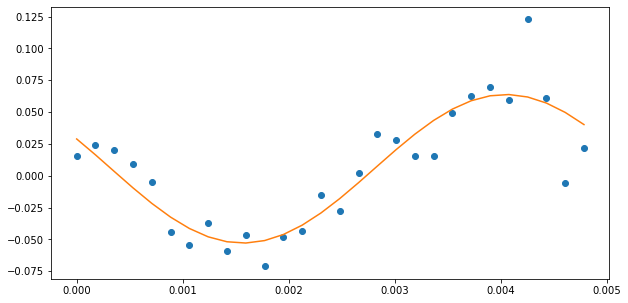

particle is:2
1314.1165714682638
Storage modulus is:325.175552920951
Loss modulus is:152.25102254735262
R^2: 0.8028096908920352
[0.05132694 2.70369745 0.02472676]


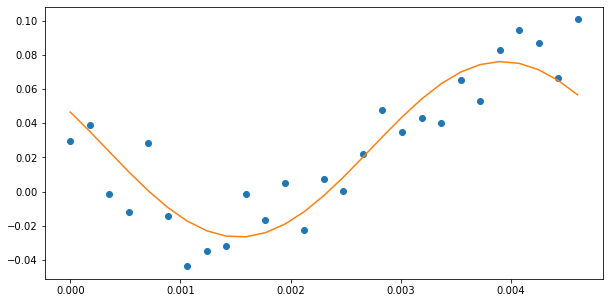

particle is:5
1267.1838367729686
Storage modulus is:173.25857398742846
Loss modulus is:217.13277735775495
R^2: 0.7274373737344836
[ 6.63428318e-02  2.24427891e+00 -1.92885378e-03]


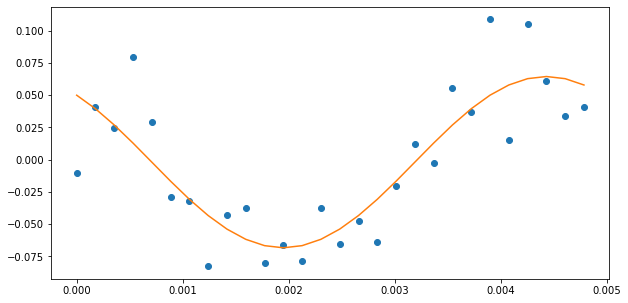

particle is:6
1419.245897185725
Storage modulus is:243.8640225643589
Loss modulus is:102.28280782046703
R^2: 0.43380186039639
[0.06968968 2.74445305 0.0062356 ]


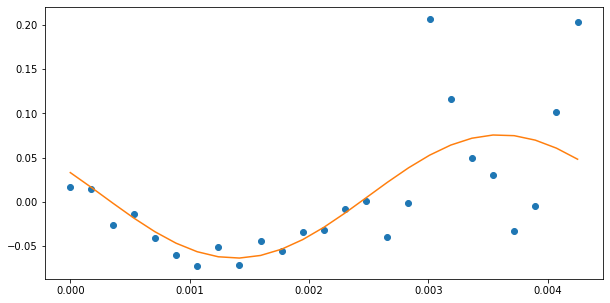

particle is:7
1314.1165714682638
Storage modulus is:292.81570040362334
Loss modulus is:158.14096686270432
R^2: 0.8754445050234757
[0.05537753 2.64640522 0.00568829]


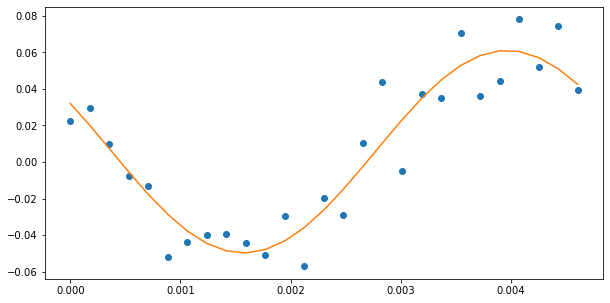

particle is:8
1267.1838367729686
Storage modulus is:346.1260788159093
Loss modulus is:187.0344281318903
R^2: 0.8251350473061251
[ 0.0468425   2.64617682 -0.00843627]


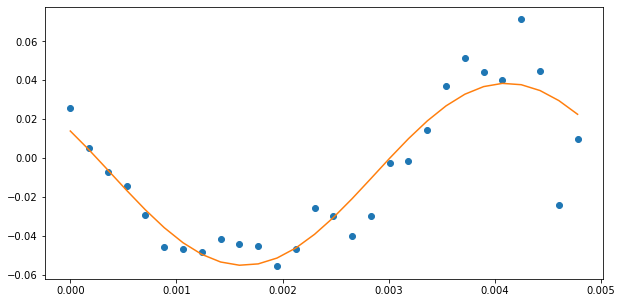

particle is:9
1314.1165714682638
Storage modulus is:265.56309281316436
Loss modulus is:142.41684462475368
R^2: 0.9072629180028577
[0.06115707 2.64934206 0.00274477]


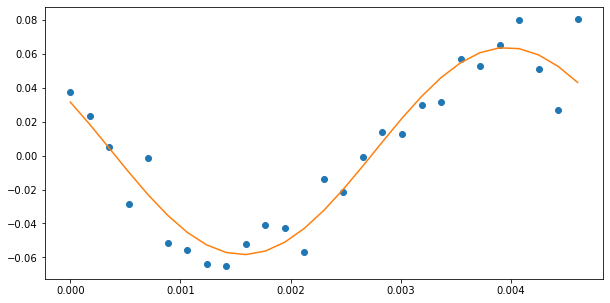

particle is:10
1314.1165714682638
Storage modulus is:283.41455617877955
Loss modulus is:127.93143770164652
R^2: 0.8083146585776934
[0.05926705 2.71758065 0.00831547]


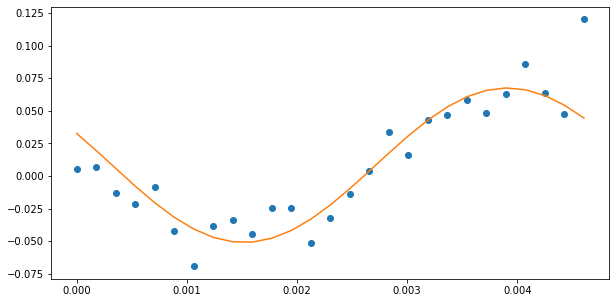

particle is:11
1314.1165714682638
Storage modulus is:285.7115506967314
Loss modulus is:112.06032917508183
R^2: 0.8053573174114979
[ 0.06004896  2.76781553 -0.01728603]


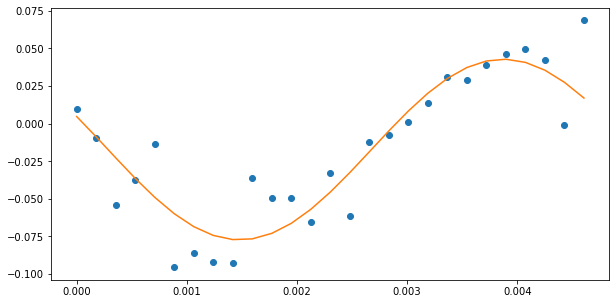

particle is:13
1314.1165714682638
Storage modulus is:350.62458682676265
Loss modulus is:97.97958128440516
R^2: 0.7443979265375839
[ 5.06215143e-02  2.86910054e+00 -2.53544954e-04]


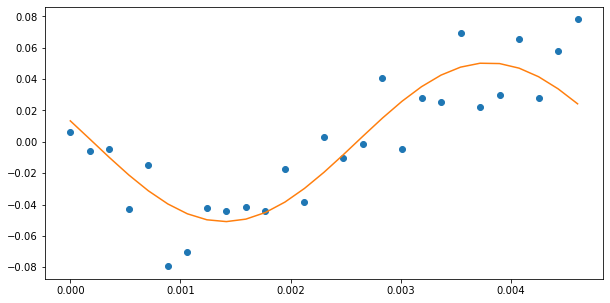

particle is:14
1314.1165714682638
Storage modulus is:325.83422411425175
Loss modulus is:167.37651451606564
R^2: 0.8348316981515558
[0.05031022 2.6670562  0.00445053]


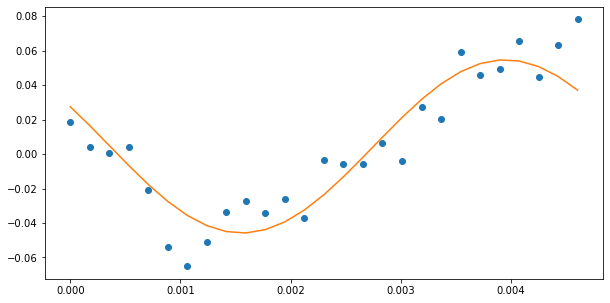

particle is:15
1314.1165714682638
Storage modulus is:234.71979159065077
Loss modulus is:88.99280772828237
R^2: 0.9588487954830461
[ 0.07341575  2.77919308 -0.01047557]


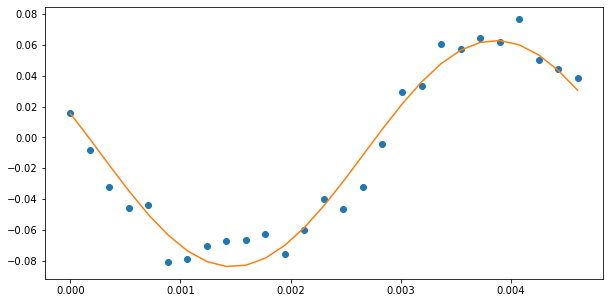

particle is:18
1419.245897185725
Storage modulus is:319.1470893617164
Loss modulus is:127.63015926845995
R^2: 0.7596662049423245
[5.36164746e-02 2.76116374e+00 2.40274221e-03]


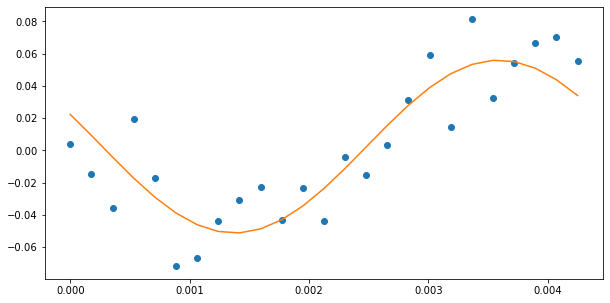

particle is:19
1314.1165714682638
Storage modulus is:336.4154661343542
Loss modulus is:190.29892516506777
R^2: 0.7745426129419053
[ 0.04768099  2.62680111 -0.00577661]


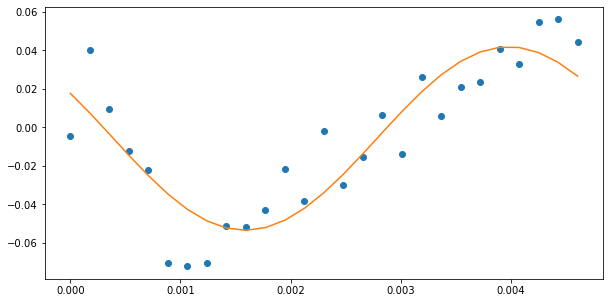

particle is:24
1314.1165714682638
Storage modulus is:294.0198822049659
Loss modulus is:66.55231698119825
R^2: 0.7718315335137153
[ 0.06113331  2.91899067 -0.00925384]


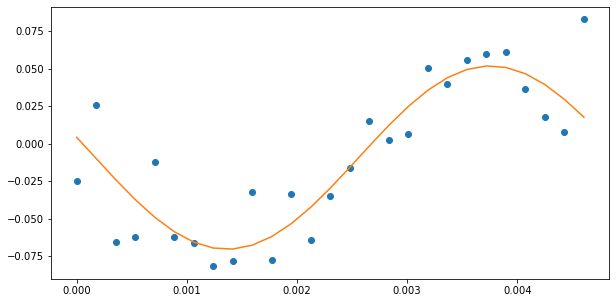

particle is:25
1267.1838367729686
Storage modulus is:311.6506321691244
Loss modulus is:140.0407785304124
R^2: 0.8730302006581766
[5.39385690e-02 2.71927789e+00 1.21011341e-04]


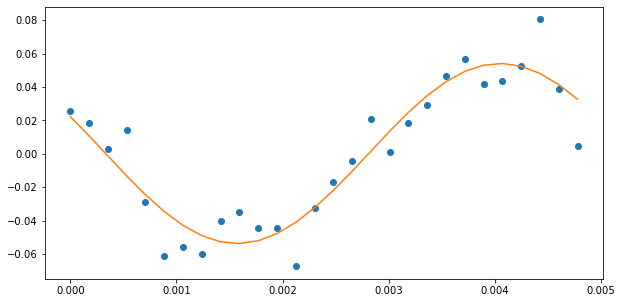

particle is:26
1267.1838367729686
Storage modulus is:229.45813009502024
Loss modulus is:144.2995693283177
R^2: 0.9272101200615382
[0.06798915 2.58021452 0.01338462]


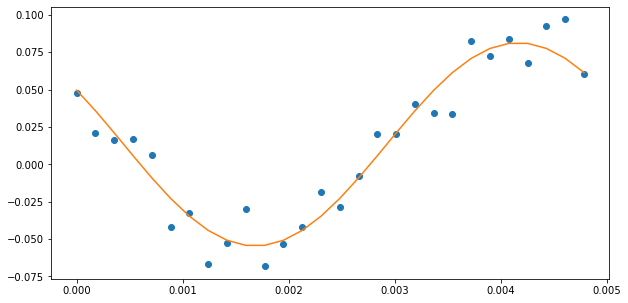

particle is:27
1267.1838367729686
Storage modulus is:311.91289848740405
Loss modulus is:105.13922991935759
R^2: 0.843108265945797
[5.59889628e-02 2.81647496e+00 1.72816437e-03]


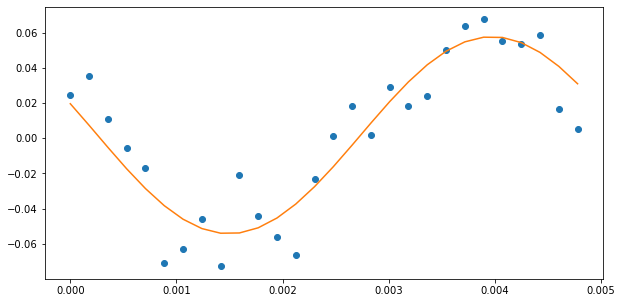

particle is:28
1314.1165714682638
Storage modulus is:362.70518994239836
Loss modulus is:93.12732422250765
R^2: 0.7814356647721168
[ 0.04921389  2.89026405 -0.00594936]


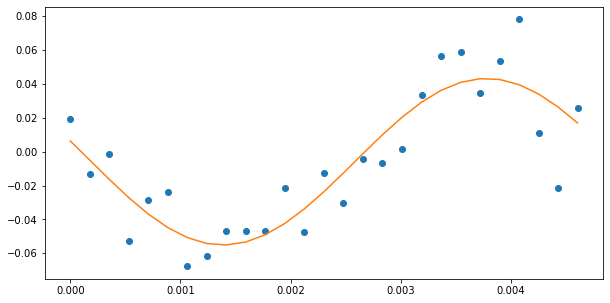

particle is:29
1267.1838367729686
Storage modulus is:409.34510338903965
Loss modulus is:153.67711335582345
R^2: 0.8163672285178849
[4.21486215e-02 2.78245216e+00 2.18380498e-03]


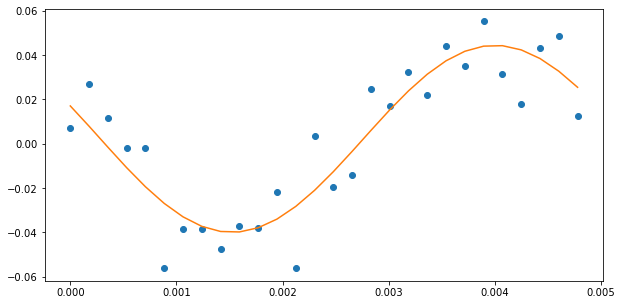

particle is:30
1314.1165714682638
Storage modulus is:392.1136056162984
Loss modulus is:213.48479784308967
R^2: 0.795565528303215
[0.04127809 2.64302332 0.00894186]


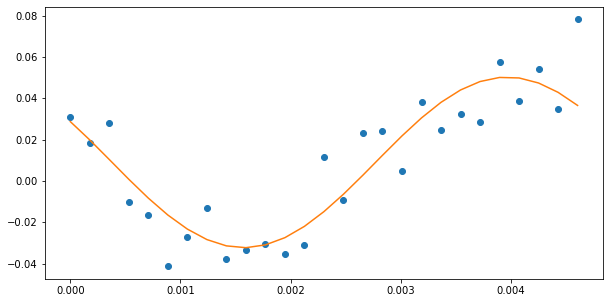

particle is:37
1267.1838367729686
Storage modulus is:264.1603768268792
Loss modulus is:109.90792357629557
R^2: 0.8268799458221767
[ 0.06441212  2.74731419 -0.0156458 ]


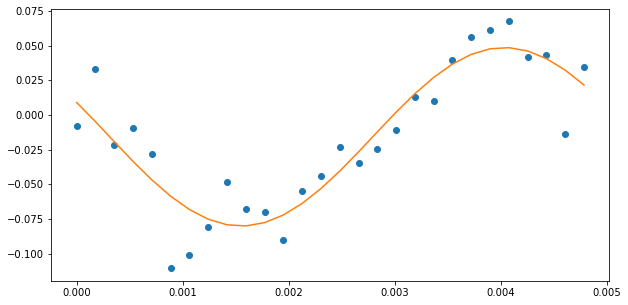

particle is:38
1314.1165714682638
Storage modulus is:374.0028963157481
Loss modulus is:123.10255560499562
R^2: 0.6534012765014383
[0.04680513 2.82361301 0.00304924]


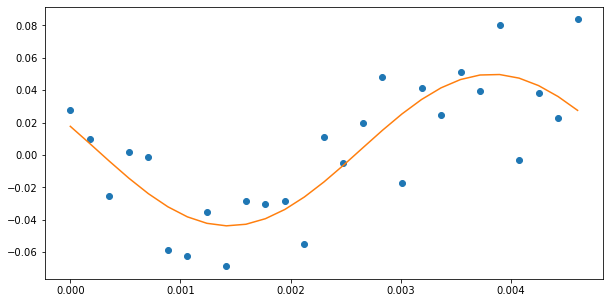

particle is:39
1314.1165714682638
Storage modulus is:259.8031488367484
Loss modulus is:116.30345467084855
R^2: 0.7783523595309892
[ 0.06474368  2.72068645 -0.01255003]


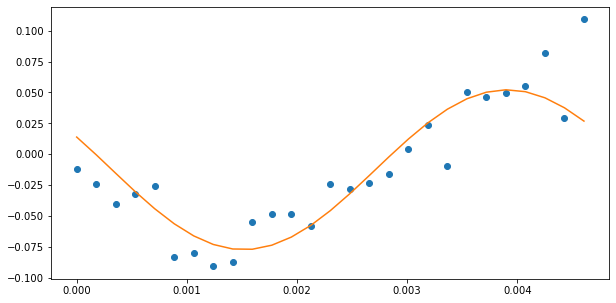

particle is:40
1314.1165714682638
Storage modulus is:336.22894981506926
Loss modulus is:64.8753043954027
R^2: 0.8191237238633369
[ 0.05381857  2.95098524 -0.00496618]


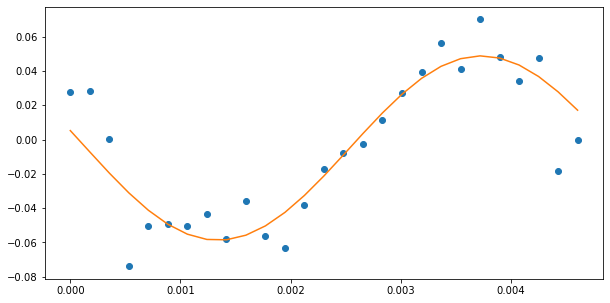

particle is:41
1314.1165714682638
Storage modulus is:243.02110732970624
Loss modulus is:57.041912309734926
R^2: 0.5674280236607474
[0.073827   2.91104606 0.00531507]


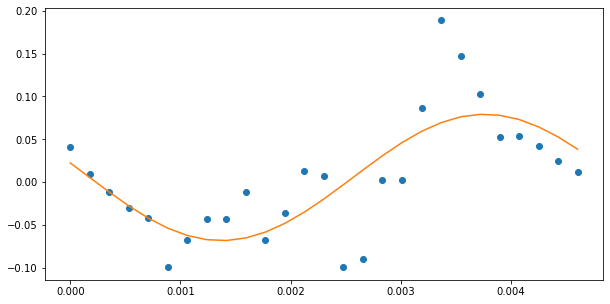

particle is:42
1267.1838367729686
Storage modulus is:306.86875355449666
Loss modulus is:122.65643919975916
R^2: 0.8733747422390182
[0.05576574 2.76134212 0.01008159]


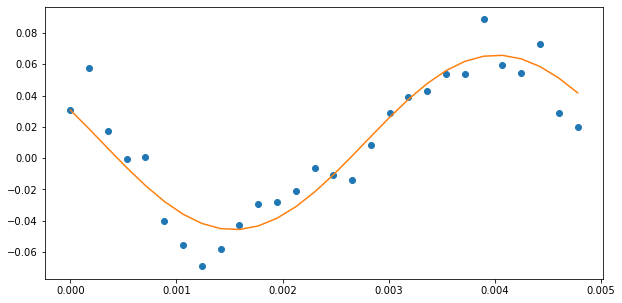

particle is:43
1267.1838367729686
Storage modulus is:226.83560860994106
Loss modulus is:82.63974358727305
R^2: 0.9202585523235063
[ 0.07633629  2.7922219  -0.02986147]


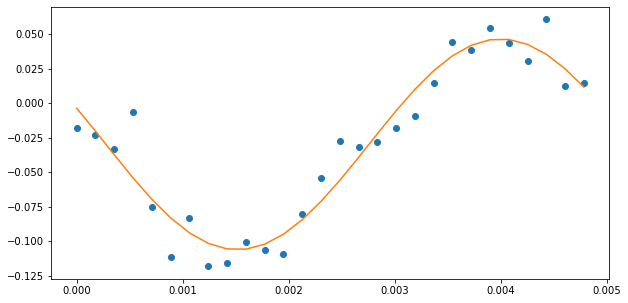

particle is:44
1314.1165714682638
Storage modulus is:282.9178928022088
Loss modulus is:101.51821977986022
R^2: 0.8662750428119653
[ 0.06131183  2.79707701 -0.02156186]


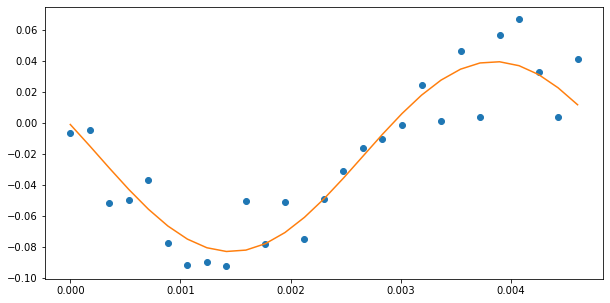

particle is:45
1314.1165714682638
Storage modulus is:205.1815550620232
Loss modulus is:88.47699469991122
R^2: 0.6805600907993461
[0.08247724 2.73447116 0.09449813]


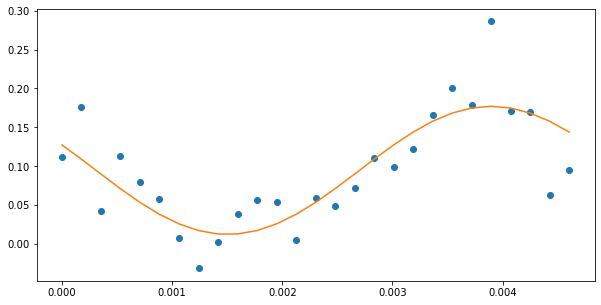

particle is:46
1314.1165714682638
Storage modulus is:239.39199463988356
Loss modulus is:111.51828980055076
R^2: 0.8940842239899148
[6.97828321e-02 2.70564481e+00 6.36555650e-04]


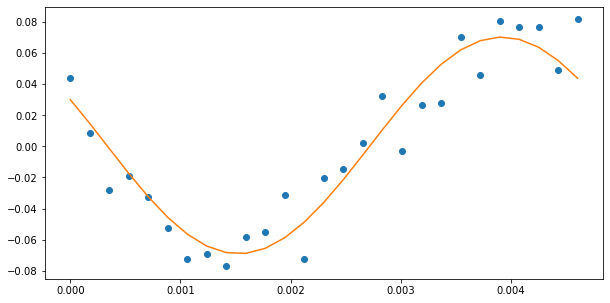

particle is:47
1314.1165714682638
Storage modulus is:4921.877792971947
Loss modulus is:2.185752820059482e-12
R^2: 0.0032887863078853163
[0.00374433 3.14159265 0.00459263]


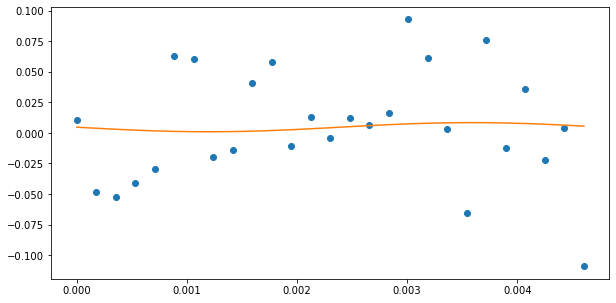

particle is:48
1314.1165714682638
Storage modulus is:343.3460517141722
Loss modulus is:88.64036416587517
R^2: 0.8432836279338997
[0.05197107 2.88894299 0.01415325]


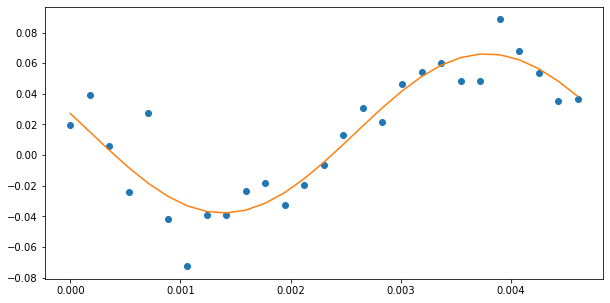

particle is:49
1267.1838367729686
Storage modulus is:277.3901801009779
Loss modulus is:130.9977236744283
R^2: 0.9071833997286206
[ 0.0600754   2.70038984 -0.01560731]


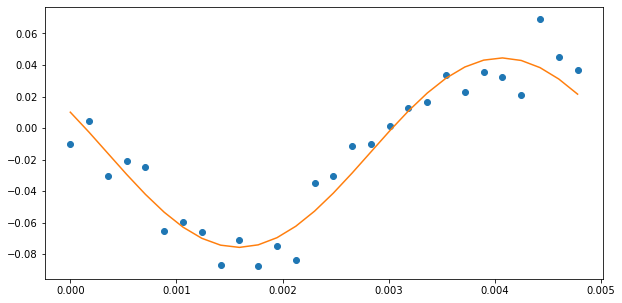

particle is:50
1314.1165714682638
Storage modulus is:425.2410781769348
Loss modulus is:73.04973747284313
R^2: 0.788465955692873
[ 0.04271242  2.97146884 -0.00381389]


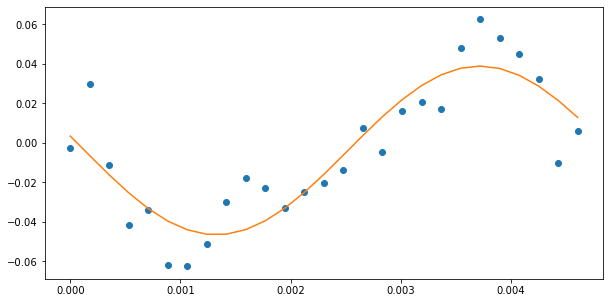

particle is:51
1314.1165714682638
Storage modulus is:312.0317453803366
Loss modulus is:40.242137957544045
R^2: 0.8639605707667188
[0.05857656 3.01333254 0.00676503]


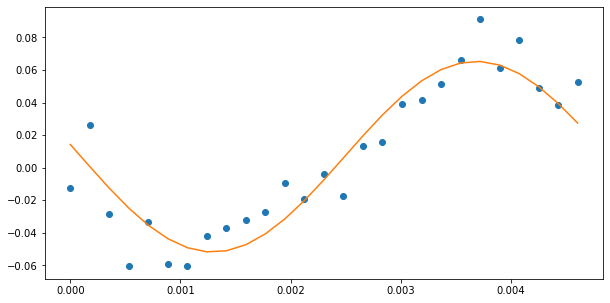

particle is:52
1075.1862857467613
Storage modulus is:2196523196.2394147
Loss modulus is:2.509806450960345
R^2: -1.591965381742e-08
[8.39013383e-09 3.14159265e+00 3.37505298e-03]


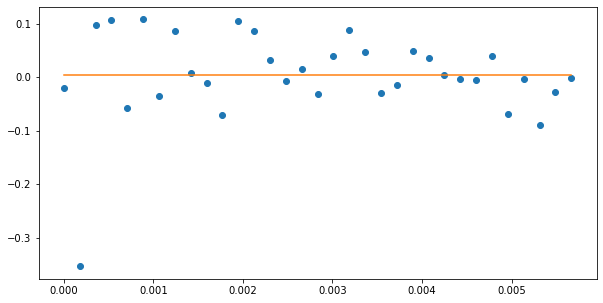

particle is:53
1314.1165714682638
Storage modulus is:320.78210535248274
Loss modulus is:153.10503723452484
R^2: 0.8440133087491926
[5.18477928e-02 2.69628022e+00 2.32149941e-03]


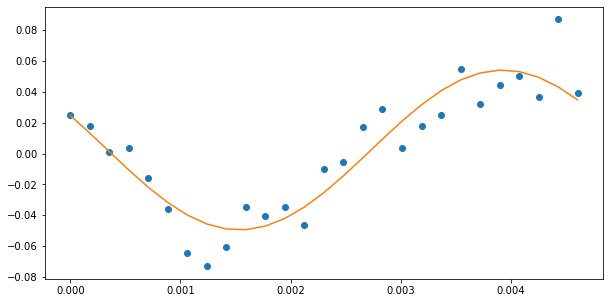

particle is:54
1314.1165714682638
Storage modulus is:151.7388590140796
Loss modulus is:135.63511171615662
R^2: -1.2497792906359932
[ 0.09055062  2.41217354 -0.1       ]


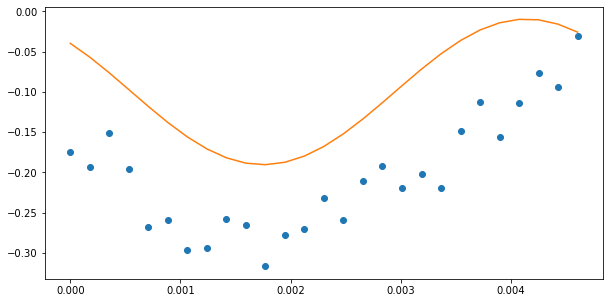

particle is:55
1314.1165714682638
Storage modulus is:234.79640178151206
Loss modulus is:159.49104374724305
R^2: 0.8714722220738953
[ 6.49272155e-02  2.54491275e+00 -8.03712114e-04]


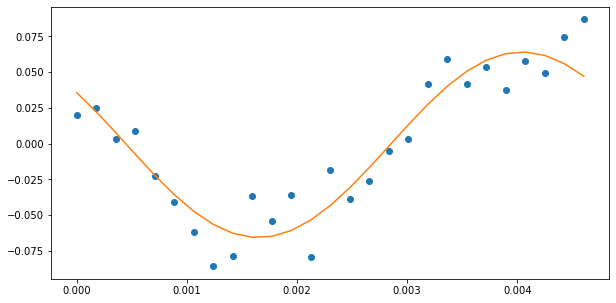

particle is:56
1314.1165714682638
Storage modulus is:279.232529060095
Loss modulus is:80.61983717402794
R^2: 0.8851549212705603
[ 0.06340923  2.86051693 -0.00738436]


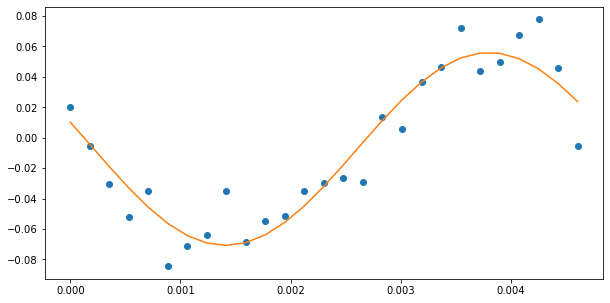

particle is:57
1314.1165714682638
Storage modulus is:259.38563457404683
Loss modulus is:140.34379069327616
R^2: 0.6416449001689482
[ 0.06248874  2.64563728 -0.03980741]


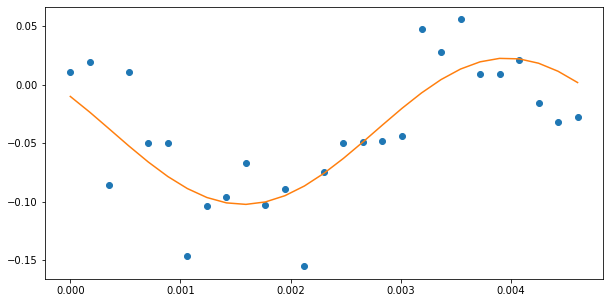

particle is:58
1314.1165714682638
Storage modulus is:151.0944360785757
Loss modulus is:191.56803419978465
R^2: 0.8903110685741306
[0.07553437 2.23862416 0.00634506]


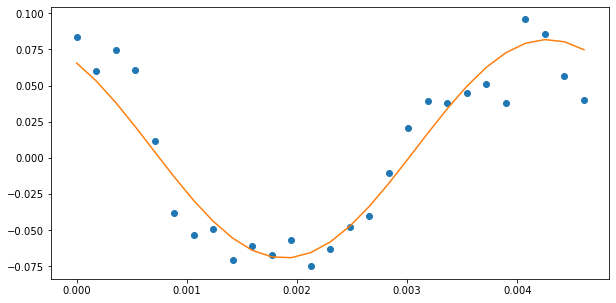

particle is:61
1314.1165714682638
Storage modulus is:386.34325076793186
Loss modulus is:389.3214937987225
R^2: 0.6108705753300795
[0.03360024 2.35235491 0.02445115]


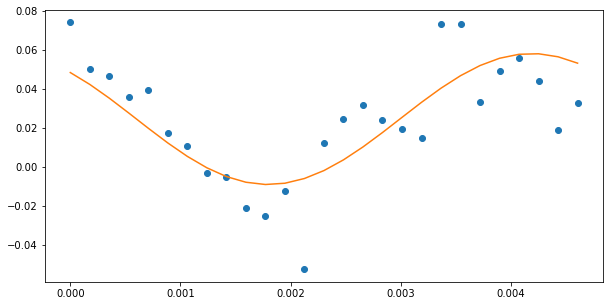

particle is:62
1314.1165714682638
Storage modulus is:286.95437947952115
Loss modulus is:101.76816949400744
R^2: 0.8796190033459097
[0.06052932 2.80078194 0.01655058]


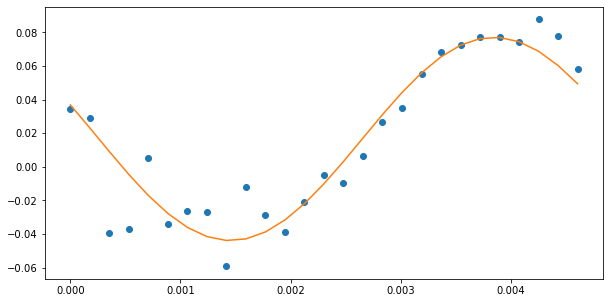

particle is:63
1314.1165714682638
Storage modulus is:284.6896363123375
Loss modulus is:84.90155115888757
R^2: 0.8616716676100236
[0.06203423 2.85176514 0.0059549 ]


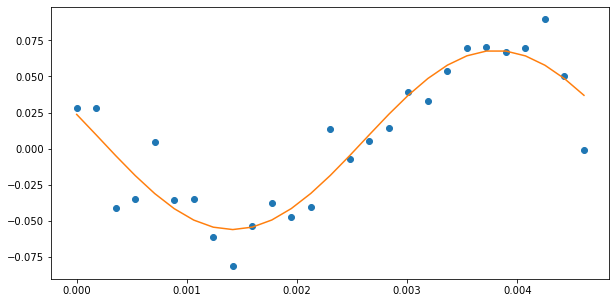

particle is:64
1314.1165714682638
Storage modulus is:328.10511622914294
Loss modulus is:115.30000743451136
R^2: 0.7931558688670021
[ 0.0529916   2.80366067 -0.01551493]


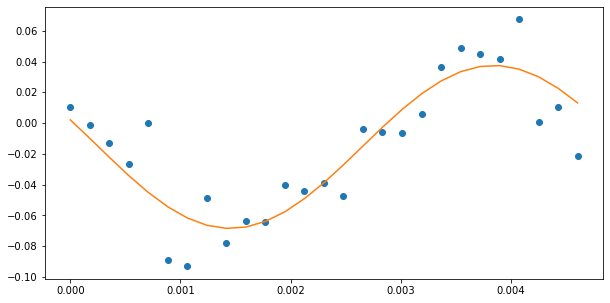

particle is:65
1314.1165714682638
Storage modulus is:360.2902283985335
Loss modulus is:116.00024348404118
R^2: 0.7891073469483995
[ 0.04868941  2.83010976 -0.00286243]


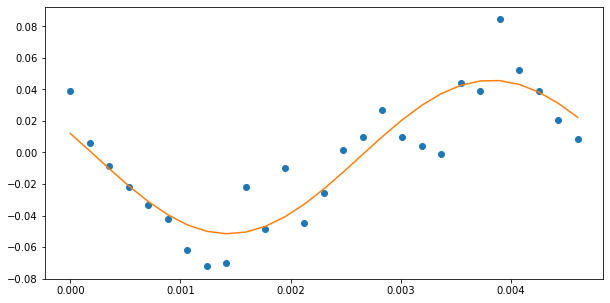

particle is:66
2087.126319390772
Storage modulus is:-53.6866609077351
Loss modulus is:14.382464956910578
R^2: 0.31976085835866663
[ 0.33157959  0.26175016 -0.01006729]


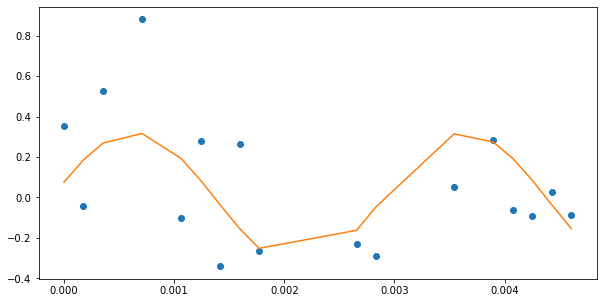

particle is:67
1314.1165714682638
Storage modulus is:333.03211452048396
Loss modulus is:91.02372564822562
R^2: 0.8782352966954493
[ 0.05337948  2.8747907  -0.0052613 ]


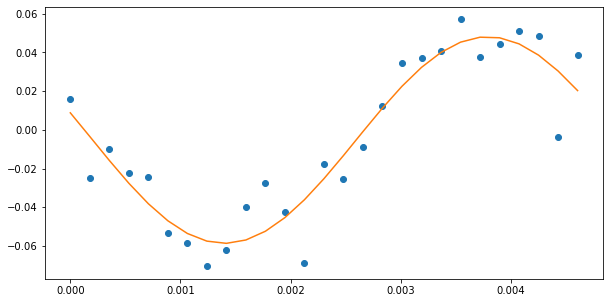

particle is:68
1314.1165714682638
Storage modulus is:267.1553758689123
Loss modulus is:116.94158798430881
R^2: 0.8630964974556522
[0.06319378 2.72899023 0.01031939]


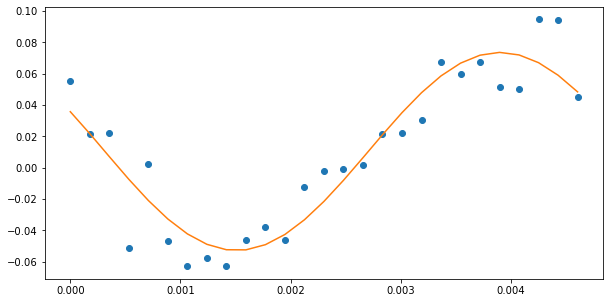

In [48]:
data2=utils.analyze_wavelength_modulus(wavelength2,gamma2list_w2,real_stress,framerate,imgname)

In [49]:
data2

,Droplet Number,Storage Modulus,Loss Modulus,Frequency,R^2,Video Name
0,0,289.321116,126.752051,1267.183837,0.806269,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...
1,2,325.175553,152.251023,1314.116571,0.802810,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...
4,7,292.815700,158.140967,1314.116571,0.875445,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...
5,8,346.126079,187.034428,1267.183837,0.825135,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...
6,9,265.563093,142.416845,1314.116571,0.907263,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...
7,10,283.414556,127.931438,1314.116571,0.808315,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...
8,11,285.711551,112.060329,1314.116571,0.805357,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...
10,14,325.834224,167.376515,1314.116571,0.834832,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...
11,15,234.719792,88.992808,1314.116571,0.958849,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...
15,25,311.650632,140.040779,1267.183837,0.873030,0p5low_alg_12p5mM_3500ul_100um_20231013_121403...


# Concatenate

In [50]:
final_output = pd.concat([data1, data2], ignore_index=True)

In [52]:
final_output.to_csv('/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/results/121507_new.csv', index=False)